# A Flexible, Encoder-Decoder Framework for Image Captioning
### *Train, Evaluate, and Compare Captioning Models*

This notebook provides a comprehensive, single-file framework to train, evaluate, and compare two distinct image captioning models. The architecture is robust, reusable, and portable, inspired by professional research pipelines.

### Core Architectures for Comparison:
The primary goal is to compare two encoder-decoder architectures:
1.  **Classic Approach**: ResNet50 (Encoder) + LSTM (Decoder).
2.  **State-of-the-Art Approach**: ViT (Encoder) + Pre-trained Transformer Decoder (GPT-2).

### Key Architectural & Workflow Requirements:
- **Modular, Multi-Step Notebook**: Structured into logical cells (e.g., "Step 1: Setup", "Step 2: Configuration") for clarity.
- **Centralized Configuration**: All settings, including model choices and hyperparameters, are managed in a central `experiment_configs` dictionary.
- **Decoupled Computation and Reporting**: The main loop handles all computation first, storing results in a dictionary. A separate, final cell generates a clean, consolidated report.
- **Portable Evaluation**: Supports an "evaluate-only" mode by loading pre-trained weights from a local path or a Google Drive zip file.
- **Data Pipeline & Vocabulary**: Includes a `Vocabulary` class to handle word-to-index mapping and special tokens (`<start>`, `<end>`, `<pad>`, `<unk>`). The DataLoader uses this to numericalize captions.
- **Advanced Training**: Implements **teacher forcing**, **two-phase fine-tuning** with **differential learning rates**, **gradient accumulation**, **early stopping**, and **caption sampling** for robust training.
- **Inference and Evaluation**: A `generate_caption` function produces text for evaluation. Standard captioning metrics are calculated: **BLEU, METEOR, and CIDEr**.

### **Step 1: Environment Setup and Dependency Installation**
This cell handles the initial setup, installing necessary packages for the project. It includes the `pycocoevalcap` library and its dependency, Java, which is essential for calculating captioning metrics.

In [1]:
import os
import subprocess
import sys
import zipfile

def run_shell_command(command, shell_mode=True):
    """Executes a shell command and raises an error if it fails."""
    try:
        print(f"Running command: {command}")
        subprocess.run(command, shell=shell_mode, check=True, capture_output=True, text=True)
    except subprocess.CalledProcessError as e:
        print(f"Error executing command: {command}")
        print(e.stderr)
        raise

def setup_environment():
    """Detects the environment and installs dependencies."""
    is_colab = "google.colab" in sys.modules
    is_runpod = os.path.exists("/workspace") or "RUNPOD_POD_ID" in os.environ
    
    if is_colab or is_runpod:
        env_type = "Google Colab" if is_colab else "RunPod"
        print(f"🚀 {env_type} environment detected. Installing dependencies...")
        
        # Install Java and Zip, dependencies for pycocoevalcap and data handling
        print("Installing Java and Zip...")
        run_shell_command("apt-get update && apt-get install -y openjdk-8-jre zip")

        # Forcibly reinstall compatible Torch and Transformers versions
        print("Cleaning and reinstalling Torch and Transformers...")
        run_shell_command("pip uninstall -y torch torchvision torchaudio transformers accelerate")
        run_shell_command("pip install torch==2.2.2 torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121")
        run_shell_command("pip install transformers==4.39.3 accelerate")

        # Install other Python packages
        print("Installing other Python packages...")
        pip_commands = [
            "pip install -q 'numpy<2.0'",
            "pip install -q pandas timm tqdm opencv-python scikit-learn nltk albumentations tabulate wandb nbformat",
            "pip install -q pycocotools pycocoevalcap kaggle matplotlib",
            "pip install -U -q ipywidgets"
        ]
        for cmd in pip_commands:
            run_shell_command(cmd)
        print(f"✅ {env_type} dependencies installed successfully.")
        
        if is_colab:
             print("\n🔥 IMPORTANT: Please restart the Colab runtime now for the new libraries to take effect! 🔥")
             print("Go to 'Runtime' > 'Restart Session' in the menu above.")
             
        return ("colab" if is_colab else "runpod"), "/content" if is_colab else "/workspace"
    else:
        print("Environment: Local machine detected.")
        return "local", os.getcwd()

def setup_from_zip(zip_path, extract_to):
    """Unzips a results archive to the base path."""
    if not os.path.exists(zip_path):
        print(f"⚠️ Zip file not found at {zip_path}. Cannot set up from zip.")
        return False
    try:
        print(f"Unzipping {zip_path} to {extract_to}...")
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_to)
        print("✅ Unzipping complete.")
        return True
    except Exception as e:
        print(f"⚠️ Failed to unzip results from {zip_path}. Error: {e}")
        return False

# Run setup and define base_path globally
env_name, base_path = setup_environment()


🚀 RunPod environment detected. Installing dependencies...
Installing Java and Zip...
Running command: apt-get update && apt-get install -y openjdk-8-jre zip
Cleaning and reinstalling Torch and Transformers...
Running command: pip uninstall -y torch torchvision torchaudio transformers accelerate
Running command: pip install torch==2.2.2 torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
Running command: pip install transformers==4.39.3 accelerate
Installing other Python packages...
Running command: pip install -q 'numpy<2.0'
Running command: pip install -q pandas timm tqdm opencv-python scikit-learn nltk albumentations tabulate wandb nbformat
Running command: pip install -q pycocotools pycocoevalcap kaggle matplotlib
Running command: pip install -U -q ipywidgets
✅ RunPod dependencies installed successfully.


### **Step 2: Main Imports and Experiment Configuration**
This cell imports all necessary libraries and defines the central `experiment_configs` dictionary. This is where you can easily switch between models (e.g., `resnet50_lstm` vs. `vit_gpt2`), adjust hyperparameters, and enable advanced training techniques like **two-phase training**, **gradient accumulation**, and **caption sampling**.

In [2]:
import glob
import json
import numpy as np
import pandas as pd
import random
import re 
import requests
import time
import shutil
from collections import Counter
from types import SimpleNamespace

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence

import timm
from transformers import AutoModel, AutoTokenizer, GPT2LMHeadModel, GPT2Tokenizer, get_cosine_schedule_with_warmup
from nltk.translate.bleu_score import corpus_bleu
from nltk.tokenize import word_tokenize
import nltk
import wandb

nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)

from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import display, Markdown
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm.notebook import tqdm

from pycocotools.coco import COCO
from pycocoevalcap.eval import COCOEvalCap

class BaseCFG:
    debug = False
    epochs = 30  # Slightly more to accommodate two-phase models
    num_workers = 2
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    force_model_retrain = False
    run_evaluation = True
    evaluate_per_epoch = True # Set to True for detailed metric tracking
    WANDB_API_KEY = "7bbf7dc1d29a93c3cd9e115741e377d149f63ee7" # Add your API key here for non-interactive login

    model_artifacts_zip_path = None

    image_size = 224
    max_length = 40  # Increased
    vocab_threshold = 3  # Lowered to allow more words

    gradient_accumulation_steps = 1
    early_stopping_patience = 10
    use_caption_sampling = True
    use_two_phase_training = True
    phase1_epochs = 5
    
experiment_configs = {
    "resnet50_lstm": {
        "models": {
            "encoder_name": "resnet50",
            "decoder_name": "lstm"
        },
        "hyperparameters": {
            "flickr8k": {
                "batch_size": 64,
                "embed_dim": 256,
                "hidden_dim": 768, # 512
                "num_layers": 1,
                "encoder_lr": 1e-4,
                "decoder_lr": 3e-4,      
                "weight_decay": 5e-4,    
                "dropout": 0.3,          
                "use_caption_sampling": True,
                "early_stopping_patience": 5, 
                "use_two_phase_training": True,
                "phase1_epochs": 8         
            },
            "flickr30k": {
                "batch_size": 96,
                "embed_dim": 512, # earlier 384
                "hidden_dim": 512,
                "num_layers": 2,
                "encoder_lr": 1e-4,
                "decoder_lr": 1.5e-4,    # From current 2e-4
                "weight_decay": 5e-4,   
                "dropout": 0.3,         
                "use_caption_sampling": True,
                "early_stopping_patience": 5, 
                "use_two_phase_training": True,
                "phase1_epochs": 10  # increased from 8      
            }
        }
    },

    "vit_gpt2": {
        "models": {
            "encoder_name": "vit_base_patch16_224",
            "decoder_name": "gpt2"
        },
        "hyperparameters": {
            "flickr8k": {
                "batch_size": 32,
                "embed_dim": 768,
                "encoder_lr": 1e-5,  # Lowered for ViT stability
                "decoder_lr": 3e-5,  # Lowered for GPT2 stability
                "weight_decay": 1e-4,
                "dropout": 0.1,      # Transformer-friendly
                "gradient_accumulation_steps": 2,
                "use_two_phase_training": True,
                "use_caption_sampling": True,
                "early_stopping_patience": 10,
                "max_length": 40
            },
            "flickr30k": {
                "batch_size": 48,
                "embed_dim": 768,
                "encoder_lr": 1e-5,
                "decoder_lr": 3e-5,
                "weight_decay": 1e-4,
                "dropout": 0.1,
                "gradient_accumulation_steps": 4,
                "use_two_phase_training": True,
                "use_caption_sampling": True,
                "early_stopping_patience": 10,
                "max_length": 40
            }
        }
    }
}

# Login to Weights & Biases
wandb_api_key = os.environ.get("WANDB_API_KEY") or BaseCFG.WANDB_API_KEY
try:
    if wandb_api_key:
        print("Logging into WandB using API key.")
        wandb.login(key=wandb_api_key)
    else:
        print("WandB API Key not found. Attempting interactive login.")
        wandb.login()
except Exception as e:
    print(f"Could not log in to WandB: {e}")
    print("Proceeding without WandB logging.")

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: lok-nammina (lok-nammina-local) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Logging into WandB using API key.


### **Step 3: Path and Data Download Utilities**
These functions manage directory creation and handle the download and extraction of the Flickr datasets. The Flickr30k download logic has been updated to use a multi-part download from GitHub, removing the need for Kaggle API keys.

In [3]:
def generate_paths(base_path, dataset_name, cfg):
    """Generates and creates all necessary directory paths for an experiment."""
    model_combo_name = f"{dataset_name}_{cfg.encoder_name.replace('/', '-')}_{cfg.decoder_name.replace('/', '-')}"
    paths = {
        "dataset_name": dataset_name,
        "dataset_dir": os.path.join(base_path, "data", dataset_name),
        "image_dir": os.path.join(base_path, "data", dataset_name, "Images"),
        "captions_file": os.path.join(base_path, "data", dataset_name, f"{dataset_name}_captions.csv"),
        "model_save_path": os.path.join(base_path, "models", f"{model_combo_name}.pt"),
        "artifact_dir": os.path.join(base_path, "artifacts", model_combo_name),
        "vocab_path": os.path.join(base_path, "artifacts", model_combo_name, "vocab.pt"),
        "history_path": os.path.join(base_path, "artifacts", model_combo_name, "train_history.pt")
    }
    for path_key in ["dataset_dir", "artifact_dir"]:
        os.makedirs(paths[path_key], exist_ok=True)
    os.makedirs(os.path.dirname(paths["model_save_path"]), exist_ok=True)
    return paths

def download_with_progress(url, filename):
    """Downloads a file from a URL with a tqdm progress bar."""
    os.makedirs(os.path.dirname(filename), exist_ok=True)
    with requests.get(url, stream=True) as r, open(filename, 'wb') as f, tqdm(
        unit="B", unit_scale=True, unit_divisor=1024, total=int(r.headers.get('content-length', 0)),
        desc=f"Downloading {os.path.basename(filename)}"
    ) as bar:
        for chunk in r.iter_content(chunk_size=8192):
            f.write(chunk)
            bar.update(len(chunk))

def download_flickr(dataset_name, target_dir):
    """Downloads and extracts the specified Flickr dataset."""
    os.makedirs(target_dir, exist_ok=True)
    print(f"📥 Downloading {dataset_name}...")
    if dataset_name == 'flickr8k':
        url = "https://github.com/awsaf49/flickr-dataset/releases/download/v1.0/flickr8k.zip"
        zip_path = os.path.join(target_dir, "flickr8k.zip")
        download_with_progress(url, zip_path)
        run_shell_command(f"unzip -q -o {zip_path} -d {target_dir}")
        os.remove(zip_path)
    elif dataset_name == 'flickr30k':
        zip_path = os.path.join(target_dir, "flickr30k.zip")
        parts = [f"flickr30k_part0{i}" for i in range(3)]
        urls = [f"https://github.com/awsaf49/flickr-dataset/releases/download/v1.0/{p}" for p in parts]
        part_paths = [os.path.join(target_dir, p) for p in parts]
        for url, part_path in zip(urls, part_paths):
            download_with_progress(url, part_path)
        
        run_shell_command(f"cat {' '.join(part_paths)} > {zip_path}")
        for part in part_paths:
            os.remove(part)
        run_shell_command(f"unzip -q -o {zip_path} -d {target_dir}")
        os.remove(zip_path)
    else:
        raise ValueError(f"Unknown dataset: {dataset_name}")

def clean_caption(text):
    """Cleans a single caption string."""
    text = str(text).lower().strip()
    text = re.sub(r'[^a-z0-9\s]', '', text)
    text = re.sub(r'\s+', ' ', text)
    return text

def process_captions(raw_captions_path, final_captions_path, cfg):
    print(f"Processing captions from {raw_captions_path}...")
    if not os.path.exists(raw_captions_path):
        print(f"❌ Missing raw captions file: {raw_captions_path}")
        return

    df = pd.read_csv(raw_captions_path)
    df.columns = df.columns.str.strip()
    df.rename(columns={"image_name": "image", "comment": "caption"}, inplace=True)
    df.dropna(subset=["caption"], inplace=True)
    df["caption"] = df["caption"].astype(str).str.strip().apply(clean_caption)
    df["num_tokens"] = df["caption"].apply(lambda x: len(x.split()))
    max_tokens = cfg.max_length - 2
    df = df[(df["num_tokens"] >= 3) & (df["num_tokens"] <= max_tokens)].reset_index(drop=True)

    df["caption_number"] = df.groupby("image").cumcount()
    df["id"] = df["image"].factorize()[0]
    df = df[["image", "caption_number", "caption", "id"]]

    df.to_csv(final_captions_path, index=False)
    print(f"\n✅ Preprocessing DONE")
    print(f"📝 Total captions: {len(df)}")
    print(f"🔤 Avg length: {df['caption'].apply(lambda x: len(x.split())).mean():.2f} tokens")
    print(f"📄 Saved: {final_captions_path}")


def prepare_dataset(config, cfg):
    """Main function to ensure dataset is downloaded and processed."""
    dataset_name = config["dataset_name"]
    dataset_dir = config["dataset_dir"]
    image_dir = config["image_dir"]
    final_captions_file = config["captions_file"]
    raw_captions_path = os.path.join(dataset_dir, 'captions.txt')

    # Stage 1: Check if the FINAL processed file exists.
    if os.path.exists(final_captions_file) and not BaseCFG.force_model_retrain:
        print(f"✅ Dataset '{dataset_name}' found and already processed. Skipping preparation.")
        return

    # Stage 2: Check if the RAW data exists.
    if not (os.path.exists(image_dir) and os.path.exists(raw_captions_path)) or BaseCFG.force_model_retrain:
        print(f"Raw dataset '{dataset_name}' not found or retraining forced. Starting download...")
        download_flickr(dataset_name, dataset_dir)
        # After download, we might have a nested folder, so let's restructure
        if not os.path.exists(image_dir) and os.path.exists(os.path.join(dataset_dir, 'flickr8k')):
            nested_dir = os.path.join(dataset_dir, 'flickr8k')
            for item in os.listdir(nested_dir):
                shutil.move(os.path.join(nested_dir, item), dataset_dir)
            shutil.rmtree(nested_dir)
        if not os.path.exists(image_dir) and os.path.exists(os.path.join(dataset_dir, 'flickr30k-images')):
            shutil.move(os.path.join(dataset_dir, 'flickr30k-images'), image_dir)
    else:
        print(f"Found raw dataset '{dataset_name}'. Skipping download.")

    # Stage 3: Process the raw data.
    print(f"Processing raw dataset...")
    process_captions(raw_captions_path, final_captions_file, cfg)
    print(f"Dataset '{dataset_name}' is now ready for use.")

### **Step 4: Vocabulary, Dataset, and DataLoader**
This is a critical section with major changes from the retrieval notebook.
- **`Vocabulary` class**: Builds a word mapping from the training captions, handling special tokens.
- **`CaptioningDataset`**: Prepares each image and its corresponding numericalized caption.
- **`get_transforms`**: Standard image augmentation for training and resizing for validation.
- **`collate_fn`**: A custom function for the DataLoader that pads caption sequences in each batch to be the same length. This is essential for batch processing in PyTorch.

In [4]:
class Vocabulary:
    def __init__(self, freq_threshold):
        self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.stoi = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3}
        self.freq_threshold = freq_threshold
        self.pad_idx = self.stoi["<PAD>"]

    def __len__(self):
        return len(self.itos)

    def build_vocabulary(self, sentence_list):
        frequencies = Counter()
        idx = 4

        for sentence in sentence_list:
            for word in word_tokenize(str(sentence)):
                frequencies[word] += 1
                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1
    
    def numericalize(self, text):
        tokenized_text = word_tokenize(str(text).lower())
        return [
            self.stoi["<SOS>"]] + [
            self.stoi[token] if token in self.stoi else self.stoi["<UNK>"] 
            for token in tokenized_text
        ] + [self.stoi["<EOS>"]]

class CaptioningDataset(Dataset):
    def __init__(self, df, image_dir, vocab, transforms, cfg):
        self.df = df
        self.image_dir = image_dir
        self.vocab = vocab
        self.transforms = transforms
        self.cfg = cfg
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        caption = self.df.caption.iloc[idx]
        image_id = self.df.image.iloc[idx]
        image_path = os.path.join(self.image_dir, image_id)
        
        try:
            image = Image.open(image_path).convert("RGB")
            image = np.array(image)
            image = self.transforms(image=image)['image']
        except (FileNotFoundError, OSError):
            # Return None if image is missing, collate_fn will handle it
            print(f"Warning: Could not load image {image_path}. Skipping.")
            return None

        numericalized_caption = self.vocab.numericalize(caption)
        caption_tensor = torch.tensor(numericalized_caption)
        
        return image, caption_tensor, image_id
    
    def update_df(self, new_df):
        """Allows the Trainer to update the dataframe, used for caption sampling."""
        self.df = new_df

def get_transforms(cfg, mode="train"):
    if mode == "train":
        return A.Compose([
            A.Resize(cfg.image_size, cfg.image_size),
            A.HorizontalFlip(p=0.5),
            A.ColorJitter(p=0.5),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2()
        ])
    else:
        return A.Compose([
            A.Resize(cfg.image_size, cfg.image_size),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2()
        ])

class Collate:
    def __init__(self, pad_idx):
        self.pad_idx = pad_idx
        
    def __call__(self, batch):
        # Filter out None values from missing images
        batch = [b for b in batch if b is not None]
        if not batch:
            return None, None, None
        
        imgs = [item[0].unsqueeze(0) for item in batch]
        imgs = torch.cat(imgs, dim=0)
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first=True, padding_value=self.pad_idx)
        image_ids = [item[2] for item in batch]
        
        return imgs, targets, image_ids
    
def make_train_valid_dfs(config):
    df = pd.read_csv(config['captions_file'])
    df = df.dropna().reset_index(drop=True)
    
    image_files_in_dir = set(os.listdir(config['image_dir']))
    df = df[df['image'].isin(image_files_in_dir)].reset_index(drop=True)
    
    # For splitting, we use unique images. For training, we use all 5 captions per image.
    unique_images = df['image'].unique()
    np.random.seed(42)
    train_mask = np.random.rand(len(unique_images)) < 0.9
    train_images = unique_images[train_mask]
    valid_images = unique_images[~train_mask]
    
    train_df = df[df['image'].isin(train_images)].reset_index(drop=True)
    # For validation, we keep all 5 captions to calculate metrics correctly
    valid_df = df[df['image'].isin(valid_images)].reset_index(drop=True)
    
    return train_df, valid_df

def build_loaders(df, image_dir, vocab, mode, config, cfg, shuffle=True):
    transforms = get_transforms(cfg, mode)
    dataset = CaptioningDataset(df, image_dir, vocab, transforms, cfg)
    
    pad_idx = vocab.pad_idx
    
    dataloader = DataLoader(
        dataset=dataset,
        batch_size=cfg.batch_size,
        num_workers=cfg.num_workers,
        shuffle=shuffle,
        collate_fn=Collate(pad_idx=pad_idx),
        pin_memory=True
    )
    return dataloader


### **Step 5: Model Definitions**
This cell defines the core Encoder-Decoder models.
- **`Encoder`**: A wrapper for `timm` models (ResNet50, ViT) to produce image features.
- **`Decoder`**: Separate implementations for the LSTM and the GPT-2 Transformer decoders.
- **`EncoderDecoder`**: The main model that combines an encoder and a decoder. It includes a `forward` method for training and a `generate_caption` method for inference.

In [5]:
class Encoder(nn.Module):
    def __init__(self, model_name, pretrained=True):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained, num_classes=0, global_pool='avg')
            
    def forward(self, x):
        return self.model(x)

class LSTMDecoder(nn.Module):
    def __init__(self, embed_dim, hidden_dim, vocab_size, num_layers, dropout):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        self.linear = nn.Linear(hidden_dim, vocab_size)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, features, captions):
        embeddings = self.dropout(self.embedding(captions))
        # Correctly expand initial hidden state for multi-layer LSTMs
        h0 = features.unsqueeze(0).repeat(self.lstm.num_layers, 1, 1)
        c0 = features.unsqueeze(0).repeat(self.lstm.num_layers, 1, 1)
        hiddens, _ = self.lstm(embeddings, (h0, c0))
        outputs = self.linear(hiddens)
        return outputs

class TransformerDecoder(nn.Module):
    def __init__(self, embed_dim, model_name="gpt2"):
        super().__init__()
        self.tokenizer = GPT2Tokenizer.from_pretrained(model_name)
        self.tokenizer.pad_token = self.tokenizer.eos_token
        self.model = GPT2LMHeadModel.from_pretrained(model_name)
        self.model.config.pad_token_id = self.model.config.eos_token_id
        
        # A linear layer to project ViT's embedding dim to GPT-2's if they differ
        self.projection = nn.Linear(embed_dim, self.model.config.n_embd)
        
    def forward(self, features, captions):
        projected_features = self.projection(features).unsqueeze(1)
        caption_embeddings = self.model.transformer.wte(captions)
        inputs_embeds = torch.cat([projected_features, caption_embeddings], dim=1)
        attention_mask = torch.ones(inputs_embeds.shape[:2], dtype=torch.long, device=features.device)
        
        outputs = self.model(inputs_embeds=inputs_embeds, attention_mask=attention_mask)
        logits = outputs.logits
        
        # Drop the prediction for the initial image feature token to align sequences
        return logits[:, :-1, :]

class EncoderDecoder(nn.Module):
    def __init__(self, cfg, vocab_size):
        super().__init__()
        self.cfg = cfg
        self.encoder = Encoder(cfg.encoder_name)
        encoder_output_dim = self.encoder.model.num_features
        
        if cfg.decoder_name == "lstm":
            # For LSTM, project encoder output to match decoder's hidden_dim
            self.feature_proj = nn.Linear(encoder_output_dim, cfg.hidden_dim)
            self.decoder = LSTMDecoder(cfg.embed_dim, cfg.hidden_dim, vocab_size, cfg.num_layers, cfg.dropout)
        elif cfg.decoder_name == "gpt2":
            # GPT-2 decoder has its own projection layer
            self.decoder = TransformerDecoder(encoder_output_dim)
        else:
            raise ValueError(f"Unknown decoder: {cfg.decoder_name}")

    def set_encoder_trainable(self, trainable=True):
        """Helper function to freeze/unfreeze the encoder's weights."""
        print(f"Setting encoder trainability to: {trainable}")
        if self.cfg.encoder_name.startswith('resnet'):
            # Freeze all layers initially
            for param in self.encoder.parameters():
                param.requires_grad = False
            
            # If fine-tuning (Phase 2), unfreeze the final block
            if trainable:
                print("  - Unfreezing final block (layer4) of ResNet for fine-tuning.")
                for param in self.encoder.model.layer4.parameters():
                    param.requires_grad = True
        else: # Default behavior for other models like ViT
            for param in self.encoder.parameters():
                param.requires_grad = trainable
            
    def forward(self, images, captions):
        features = self.encoder(images)
        if self.cfg.decoder_name == "lstm":
            features = self.feature_proj(features)
            # Slicing for teacher forcing is now handled in the Trainer
            outputs = self.decoder(features, captions)
        else: # GPT-2
            outputs = self.decoder(features, captions)
        return outputs

    def generate_caption(self, image, vocab, max_length=30):
        self.eval()
        result_caption = []
        
        with torch.no_grad():
            image = image.unsqueeze(0).to(self.cfg.device)
            features = self.encoder(image)
            
            if self.cfg.decoder_name == "lstm":
                features = self.feature_proj(features)
                states = (features.unsqueeze(0).repeat(self.decoder.lstm.num_layers, 1, 1), 
                          features.unsqueeze(0).repeat(self.decoder.lstm.num_layers, 1, 1))
                inputs = self.decoder.embedding(torch.tensor([vocab.stoi["<SOS>"]]).to(self.cfg.device)).unsqueeze(1)
                
                for _ in range(max_length):
                    hiddens, states = self.decoder.lstm(inputs, states)
                    outputs = self.decoder.linear(hiddens.squeeze(1))
                    predicted_idx = outputs.argmax(1)
                    inputs = self.decoder.embedding(predicted_idx).unsqueeze(1)
                    
                    if predicted_idx.item() == vocab.stoi["<EOS>"]:
                        break
                    result_caption.append(vocab.itos[predicted_idx.item()])
            else: # GPT-2
                features = self.decoder.projection(features).unsqueeze(1)
                attention_mask = torch.ones(features.shape[:2], dtype=torch.long, device=features.device)
                output_ids = self.decoder.model.generate(
                    inputs_embeds=features, 
                    attention_mask=attention_mask,
                    max_length=max_length, 
                    num_beams=5, 
                    early_stopping=True, 
                    pad_token_id=self.decoder.tokenizer.eos_token_id,
                    eos_token_id=self.decoder.tokenizer.eos_token_id
                )
                caption = self.decoder.tokenizer.decode(output_ids[0], skip_special_tokens=True)
                return caption.strip()
                
        return " ".join(result_caption)

### **Step 6: Trainer and Utilities**
- **`AvgMeter`**: A simple utility for tracking average metrics.
- **`Trainer`**: Manages the training and validation loops. The loops are adapted for a sequence-to-sequence task, calculating loss at each timestep.

In [6]:
class AvgMeter:
    def __init__(self, name="Metric"): self.name, self.avg, self.sum, self.count = name, 0, 0, 0
    def update(self, val, n=1): self.sum += val * n; self.count += n; self.avg = self.sum / self.count
    def __repr__(self): return f"{self.name}: {self.avg:.4f}"

class Trainer:
    def __init__(self, model, loss_fn, optimizer, scheduler, cfg):
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.cfg = cfg
        self.device = cfg.device

    def _train_one_epoch(self, train_loader):
        loss_meter = AvgMeter()
        self.model.train()
        progress_bar = tqdm(train_loader, total=len(train_loader), desc="Training")
        self.optimizer.zero_grad() # Reset gradients at the start of the epoch
        
        for i, (images, captions, _) in enumerate(progress_bar):
            if images is None: continue
            images, captions = images.to(self.device), captions.to(self.device)
            
            outputs = self.model(images, captions[:, :-1])
            loss = self.loss_fn(outputs.reshape(-1, outputs.shape[2]), captions[:, 1:].reshape(-1))
            
            # Gradient Accumulation
            loss = loss / self.cfg.gradient_accumulation_steps
            loss.backward()

            if (i + 1) % self.cfg.gradient_accumulation_steps == 0:
                self.optimizer.step()
                self.optimizer.zero_grad()
                if self.scheduler: self.scheduler.step()
                
            loss_meter.update(loss.item() * self.cfg.gradient_accumulation_steps, images.size(0))
            progress_bar.set_postfix(train_loss=loss_meter.avg, lr=self.optimizer.param_groups[0]['lr'])
            
        return loss_meter

    def _valid_one_epoch(self, valid_loader):
        loss_meter = AvgMeter()
        self.model.eval()
        progress_bar = tqdm(valid_loader, total=len(valid_loader), desc="Validation")
        with torch.no_grad():
            for images, captions, _ in progress_bar:
                if images is None: continue
                images, captions = images.to(self.device), captions.to(self.device)
                
                outputs = self.model(images, captions[:, :-1])
                loss = self.loss_fn(outputs.reshape(-1, outputs.shape[2]), captions[:, 1:].reshape(-1))
                
                loss_meter.update(loss.item(), images.size(0))
                progress_bar.set_postfix(valid_loss=loss_meter.avg)
        return loss_meter

    def fit(self, train_loader, valid_loader, config, start_epoch=0):
        best_loss = float('inf')
        history = {"train_loss": [], "valid_loss": [], "epoch_times": []}
        patience_counter = 0

        for epoch in range(start_epoch, self.cfg.epochs):
            epoch_start_time = time.time()
            print(f"\nEpoch: {epoch + 1}/{self.cfg.epochs}")
            
            # Caption Sampling
            current_train_loader = train_loader
            if self.cfg.use_caption_sampling:
                print("Sampling one caption per image for training this epoch...")
                sampled_df = train_loader.dataset.df.groupby('image').sample(1).reset_index(drop=True)
                current_train_loader = build_loaders(sampled_df, train_loader.dataset.image_dir, train_loader.dataset.vocab, 'train', {}, self.cfg, shuffle=True)
            
            train_loss = self._train_one_epoch(current_train_loader)
            valid_loss = self._valid_one_epoch(valid_loader)
            
            epoch_end_time = time.time()
            epoch_duration = epoch_end_time - epoch_start_time
            history['train_loss'].append(train_loss.avg)
            history['valid_loss'].append(valid_loss.avg)
            history['epoch_times'].append(epoch_duration)
            
            print(f"Epoch {epoch+1} | Train Loss: {train_loss.avg:.4f} | Valid Loss: {valid_loss.avg:.4f} | Time: {epoch_duration:.2f}s")
            
            if self.cfg.evaluate_per_epoch:
                # Simplified evaluation (BLEU-4 only) for per-epoch tracking
                temp_scores, _, _ = generate_and_evaluate(self.model, valid_loader, train_loader.dataset.vocab, config)
                wandb.log({"val_bleu4": temp_scores.get("Bleu_4", 0), "epoch": epoch})

            wandb.log({"train_loss": train_loss.avg, "valid_loss": valid_loss.avg, "epoch": epoch})

            if valid_loss.avg < best_loss:
                best_loss = valid_loss.avg
                torch.save({'epoch': epoch + 1, 'model_state_dict': self.model.state_dict(), 'optimizer_state_dict': self.optimizer.state_dict()}, self.cfg.model_save_path)
                print(f"Saved Best Model! Validation Loss: {best_loss:.4f}")
                patience_counter = 0
            else:
                patience_counter += 1
                print(f"Validation loss did not improve. Patience: {patience_counter}/{self.cfg.early_stopping_patience}")
                if patience_counter >= self.cfg.early_stopping_patience:
                    print("Early stopping triggered.")
                    break
        
        return history


### **Step 7: Evaluation and Reporting Functions**
These functions handle the caption generation for the entire validation set and then use the `pycocoevalcap` library to compute standard metrics.
- **`generate_and_evaluate`**: Iterates through the validation loader, generates a caption for each image, and stores the results.
- **`get_coco_scores`**: Formats the generated captions and ground truths into the required JSON structure and runs the COCO evaluation scripts.

In [7]:
def generate_and_evaluate(model, dataloader, vocab, config):
    """Generates captions for a dataloader and prepares data for COCO evaluation."""
    print(f"Generating captions for {config['dataset_name']} validation set...")
    model.eval()
    
    results = []
    ground_truths = []
    image_ids_processed = set()
    
    with torch.no_grad():
        for images, captions_gt, image_ids in tqdm(dataloader, desc="Generating Captions"):
            if images is None: continue
            images = images.to(BaseCFG.device)
            
            for i in range(images.size(0)):
                image_id = image_ids[i]
                
                if image_id not in image_ids_processed:
                    generated_caption = model.generate_caption(images[i], vocab)
                    results.append({"image_id": image_id, "caption": generated_caption})
                    image_ids_processed.add(image_id)
    
    # Prepare ground truths from the validation dataframe
    valid_df = dataloader.dataset.df
    annotations = []
    images_info = []
    ann_id_counter = 1
    for img_id in image_ids_processed:
        images_info.append({"id": img_id})
        captions_for_image = valid_df[valid_df['image'] == img_id]['caption'].tolist()
        for cap in captions_for_image:
            annotations.append({"image_id": img_id, "id": ann_id_counter, "caption": cap})
            ann_id_counter += 1
    
    ground_truths = {
        "info": {"description": "Ground-truth captions for evaluation"},
        "images": images_info,
        "licenses": [],
        "annotations": annotations,
        "type": "captions"
    }
    
    # Calculate scores
    scores = get_coco_scores(results, ground_truths, config["artifact_dir"])
    return scores, results, ground_truths

def get_coco_scores(res, gts, artifact_dir):
    """Uses pycocoevalcap to calculate captioning metrics."""
    # Ensure artifact directory exists
    os.makedirs(artifact_dir, exist_ok=True)
    res_file = os.path.join(artifact_dir, "results.json")
    gts_file = os.path.join(artifact_dir, "ground_truths.json")
    
    with open(res_file, "w") as f:
        json.dump(res, f)
        
    with open(gts_file, "w") as f:
        json.dump(gts, f)

    coco = COCO(gts_file)
    coco_res = coco.loadRes(res_file)

    coco_eval = COCOEvalCap(coco, coco_res)
    coco_eval.evaluate()

    return coco_eval.eval

def get_parameter_counts(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params, trainable_params


### **Step 8: The Main Pipeline Function**
This function orchestrates the entire process for a single experiment: data preparation, vocabulary building, model training (or loading), evaluation, and result aggregation. It returns a dictionary containing all results and artifacts.

In [8]:
def run_pipeline(config, cfg):
    print("-" * 50)
    print(f"STARTING PIPELINE FOR: {config['dataset_name'].upper()}")
    print(f"With model: {cfg.encoder_name} + {cfg.decoder_name}")
    print("-" * 50)
    
    # --- Setup: Data & Vocabulary ---
    print("\nSetting up datasets and vocabulary...")
    prepare_dataset(config, cfg)
    train_df, valid_df = make_train_valid_dfs(config)
    
    if train_df is None or valid_df is None or train_df.empty or valid_df.empty:
        print("Could not create dataframes. Aborting.")
        return None
        
    vocab = Vocabulary(freq_threshold=cfg.vocab_threshold)
    if os.path.exists(config["vocab_path"]) and not cfg.force_model_retrain:
        print("Loading existing vocabulary...")
        vocab = torch.load(config["vocab_path"], weights_only=False)
    else:
        print("Building new vocabulary...")
        vocab.build_vocabulary(train_df.caption.tolist())
        torch.save(vocab, config["vocab_path"])
    vocab_size = len(vocab)
    print(f"Vocabulary size: {vocab_size}")

    # Build data loaders
    train_loader = build_loaders(train_df, config['image_dir'], vocab, 'train', config, cfg, shuffle=True)
    valid_loader = build_loaders(valid_df, config['image_dir'], vocab, 'valid', config, cfg, shuffle=False)
    
    # --- Model Creation and Loading ---
    print("\nCreating model...")
    model = EncoderDecoder(cfg, vocab_size).to(cfg.device)
    cfg.model_save_path = config['model_save_path'] # Pass save path to Trainer
    
    training_history = None
    total_training_duration = 0
    
    if os.path.exists(cfg.model_save_path) and not cfg.force_model_retrain:
        print(f"Model found at '{cfg.model_save_path}'. Loading weights...")
        checkpoint = torch.load(cfg.model_save_path, map_location=cfg.device)
        model.load_state_dict(checkpoint['model_state_dict'])
        if os.path.exists(config['history_path']):
            training_history = torch.load(config['history_path'])
    else:
        # --- Training --- #
        start_time = time.time()
        if cfg.use_two_phase_training:
            # Phase 1: Train only the decoder
            print("--- Starting Two-Phase Training: Phase 1 (Decoder Only) ---")
            model.set_encoder_trainable(False)
            decoder_params = [p for p in model.parameters() if p.requires_grad]
            optimizer = torch.optim.Adam(decoder_params, lr=cfg.decoder_lr, weight_decay=cfg.weight_decay)
            trainer = Trainer(model, nn.CrossEntropyLoss(ignore_index=vocab.pad_idx), optimizer, None, cfg)
            cfg.epochs = cfg.phase1_epochs # Temporarily set epochs for phase 1
            history1 = trainer.fit(train_loader, valid_loader, config)
            
            # Phase 2: Train the full model with differential learning rates
            print("--- Two-Phase Training: Phase 2 (Full Model with Differential LRs) ---")
            model.set_encoder_trainable(True)
            optimizer_params = [
                {"params": model.encoder.parameters(), "lr": cfg.encoder_lr},
                {"params": model.decoder.parameters(), "lr": cfg.decoder_lr}
            ]
            optimizer = torch.optim.Adam(optimizer_params, weight_decay=cfg.weight_decay)
            trainer = Trainer(model, nn.CrossEntropyLoss(ignore_index=vocab.pad_idx), optimizer, None, cfg)
            cfg.epochs = BaseCFG.epochs # Reset to original epochs
            history2 = trainer.fit(train_loader, valid_loader, config, start_epoch=cfg.phase1_epochs)
            
            # Combine histories
            training_history = {k: history1[k] + history2[k] for k in history1}
        else:
            # Standard one-phase training
            print("--- Starting Standard Training ---")
            optimizer = torch.optim.Adam(model.parameters(), lr=cfg.decoder_lr, weight_decay=cfg.weight_decay)
            trainer = Trainer(model, nn.CrossEntropyLoss(ignore_index=vocab.pad_idx), optimizer, None, cfg)
            training_history = trainer.fit(train_loader, valid_loader, config)
            
        total_training_duration = time.time() - start_time
        torch.save(training_history, config['history_path'])

    if not cfg.run_evaluation:
        print("Skipping evaluation as per configuration.")
        return {"history": training_history, "model": model, "config": config, "cfg": cfg, "vocab": vocab, "train_loader_len": len(train_loader)}

    # --- Evaluation ---
    print("\nStarting evaluation...")
    scores, generated_captions, ground_truths = generate_and_evaluate(model, valid_loader, vocab, config)
        
    print(f"\nPIPELINE FOR {config['dataset_name'].upper()} COMPLETE")
    return {
        "history": training_history,
        "metrics": scores,
        "generated_captions": generated_captions,
        "ground_truths": ground_truths,
        "model": model, 
        "config": config, 
        "cfg": cfg,
        "vocab": vocab,
        "duration": total_training_duration,
        "train_loader_len": len(train_loader)
    }


### **Step 9: Main Execution Loop**
This cell runs the main pipeline. It iterates through the `experiment_configs`, sets up the configuration for each run, and calls the `run_pipeline` function. All results are collected in the `results_history` dictionary for the final reporting step.

In [9]:
if __name__ == '__main__':
    results_history = {}
    
    if BaseCFG.model_artifacts_zip_path and setup_from_zip(BaseCFG.model_artifacts_zip_path, base_path):
        print("\n📦 Switched to 'Evaluation from Zip' mode.")
        BaseCFG.force_model_retrain = False
    
    experiments_to_run = ["resnet50_lstm"] # , "vit_gpt2"
    datasets_to_process = ["flickr8k", "flickr30k"]

    for exp_name in experiments_to_run:
        if exp_name not in experiment_configs:
            print(f"Skipping unknown experiment: {exp_name}")
            continue
            
        print("\n" + "="*80)
        print(f"                RUNNING EXPERIMENT: {exp_name.upper()}")
        print("="*80 + "\n")
        
        exp_params = experiment_configs[exp_name]
        
        for dataset_name in datasets_to_process:
            base_cfg_dict = {k: v for k, v in BaseCFG.__dict__.items() if not k.startswith('__')}
            # Overwrite base config with experiment-specific ones
            hyperparams = {**base_cfg_dict, **exp_params.get("hyperparameters", {}).get(dataset_name, {})}
            combined_params = {**hyperparams, **exp_params["models"]}
            cfg = SimpleNamespace(**combined_params)
            
            path_config = generate_paths(base_path, dataset_name, cfg)
            
            try:
                wandb.init(
                    project="image-captioning-experiments",
                    name=f"{exp_name}-{dataset_name}-{int(time.time())}",
                    config=vars(cfg)
                )
                run_results = run_pipeline(path_config, cfg)
                if run_results:
                    if dataset_name not in results_history:
                        results_history[dataset_name] = {}
                    results_history[dataset_name][exp_name] = run_results
                    wandb.log(run_results['metrics'])
            except Exception as e:
                print(f"\n❌ An error occurred during the pipeline for {exp_name} on {dataset_name}.")
                print(f"Error: {e}")
                import traceback
                traceback.print_exc()
            finally:
                wandb.finish()
                



                RUNNING EXPERIMENT: RESNET50_LSTM



--------------------------------------------------
STARTING PIPELINE FOR: FLICKR8K
With model: resnet50 + lstm
--------------------------------------------------

Setting up datasets and vocabulary...
✅ Dataset 'flickr8k' found and already processed. Skipping preparation.
Loading existing vocabulary...
Vocabulary size: 3916

Creating model...


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


--- Starting Two-Phase Training: Phase 1 (Decoder Only) ---
Setting encoder trainability to: False

Epoch: 1/8
Sampling one caption per image for training this epoch...


Training:   0%|          | 0/115 [00:00<?, ?it/s]

Validation:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 1 | Train Loss: 5.2793 | Valid Loss: 4.4505 | Time: 19.01s
Generating captions for flickr8k validation set...


Generating Captions:   0%|          | 0/62 [00:00<?, ?it/s]

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...


PTBTokenizer tokenized 46581 tokens at 471275.99 tokens per second.
PTBTokenizer tokenized 5393 tokens at 112140.38 tokens per second.


setting up scorers...
computing Bleu score...
{'testlen': 4604, 'reflen': 5884, 'guess': [4604, 3814, 3024, 2234], 'correct': [2786, 830, 202, 74]}
ratio: 0.7824609109448024
Bleu_1: 0.458
Bleu_2: 0.275
Bleu_3: 0.156
Bleu_4: 0.099
computing METEOR score...
METEOR: 0.089
computing Rouge score...
ROUGE_L: 0.355
computing CIDEr score...
CIDEr: 0.057
computing SPICE score...


Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.3 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [0.8 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.5

SPICE evaluation took: 6.976 s
SPICE: 0.027
Saved Best Model! Validation Loss: 4.4505

Epoch: 2/8
Sampling one caption per image for training this epoch...


Training:   0%|          | 0/115 [00:00<?, ?it/s]

Validation:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 2 | Train Loss: 4.2885 | Valid Loss: 4.0489 | Time: 19.03s
Generating captions for flickr8k validation set...


Generating Captions:   0%|          | 0/62 [00:00<?, ?it/s]

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...


PTBTokenizer tokenized 46581 tokens at 483235.85 tokens per second.
PTBTokenizer tokenized 8771 tokens at 159101.41 tokens per second.


setting up scorers...
computing Bleu score...
{'testlen': 7982, 'reflen': 7841, 'guess': [7982, 7192, 6402, 5612], 'correct': [4104, 1367, 354, 135]}
ratio: 1.0179824002039257
Bleu_1: 0.514
Bleu_2: 0.313
Bleu_3: 0.175
Bleu_4: 0.107
computing METEOR score...
METEOR: 0.136
computing Rouge score...
ROUGE_L: 0.372
computing CIDEr score...
CIDEr: 0.161
computing SPICE score...


Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.3 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [0.8 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.5

SPICE evaluation took: 8.689 s
SPICE: 0.061
Saved Best Model! Validation Loss: 4.0489

Epoch: 3/8
Sampling one caption per image for training this epoch...


Training:   0%|          | 0/115 [00:00<?, ?it/s]

Validation:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 3 | Train Loss: 4.0310 | Valid Loss: 3.8516 | Time: 18.84s
Generating captions for flickr8k validation set...


Generating Captions:   0%|          | 0/62 [00:00<?, ?it/s]

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...


PTBTokenizer tokenized 46581 tokens at 493029.63 tokens per second.
PTBTokenizer tokenized 8843 tokens at 162199.03 tokens per second.


setting up scorers...
computing Bleu score...
{'testlen': 8054, 'reflen': 7895, 'guess': [8054, 7264, 6474, 5684], 'correct': [4195, 1434, 357, 127]}
ratio: 1.0201393286889144
Bleu_1: 0.521
Bleu_2: 0.321
Bleu_3: 0.178
Bleu_4: 0.106
computing METEOR score...
METEOR: 0.136
computing Rouge score...
ROUGE_L: 0.378
computing CIDEr score...
CIDEr: 0.142
computing SPICE score...


Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.3 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [0.8 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.5

SPICE evaluation took: 6.506 s
SPICE: 0.058
Saved Best Model! Validation Loss: 3.8516

Epoch: 4/8
Sampling one caption per image for training this epoch...


Training:   0%|          | 0/115 [00:00<?, ?it/s]

Validation:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 4 | Train Loss: 3.8814 | Valid Loss: 3.7175 | Time: 19.04s
Generating captions for flickr8k validation set...


Generating Captions:   0%|          | 0/62 [00:00<?, ?it/s]

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...


PTBTokenizer tokenized 46581 tokens at 496727.90 tokens per second.
PTBTokenizer tokenized 13840 tokens at 211163.28 tokens per second.


setting up scorers...
computing Bleu score...
{'testlen': 13051, 'reflen': 10334, 'guess': [13051, 12261, 11471, 10681], 'correct': [4793, 1459, 403, 158]}
ratio: 1.2629185213855947
Bleu_1: 0.367
Bleu_2: 0.209
Bleu_3: 0.115
Bleu_4: 0.069
computing METEOR score...
METEOR: 0.137
computing Rouge score...
ROUGE_L: 0.332
computing CIDEr score...
CIDEr: 0.145
computing SPICE score...


Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.3 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [0.7 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.5

SPICE evaluation took: 10.74 s
SPICE: 0.069
Saved Best Model! Validation Loss: 3.7175

Epoch: 5/8
Sampling one caption per image for training this epoch...


Training:   0%|          | 0/115 [00:00<?, ?it/s]

Validation:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 5 | Train Loss: 3.7737 | Valid Loss: 3.6294 | Time: 19.07s
Generating captions for flickr8k validation set...


Generating Captions:   0%|          | 0/62 [00:00<?, ?it/s]

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...


PTBTokenizer tokenized 46581 tokens at 456767.54 tokens per second.
PTBTokenizer tokenized 8728 tokens at 153347.48 tokens per second.


setting up scorers...
computing Bleu score...
{'testlen': 7939, 'reflen': 7825, 'guess': [7939, 7149, 6359, 5569], 'correct': [3929, 1276, 340, 121]}
ratio: 1.014568690095717
Bleu_1: 0.495
Bleu_2: 0.297
Bleu_3: 0.168
Bleu_4: 0.101
computing METEOR score...
METEOR: 0.137
computing Rouge score...
ROUGE_L: 0.361
computing CIDEr score...
CIDEr: 0.174
computing SPICE score...


Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.3 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [0.7 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.5

SPICE evaluation took: 7.427 s
SPICE: 0.070
Saved Best Model! Validation Loss: 3.6294

Epoch: 6/8
Sampling one caption per image for training this epoch...


Training:   0%|          | 0/115 [00:00<?, ?it/s]

Validation:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 6 | Train Loss: 3.7060 | Valid Loss: 3.5626 | Time: 19.18s
Generating captions for flickr8k validation set...


Generating Captions:   0%|          | 0/62 [00:00<?, ?it/s]

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...


PTBTokenizer tokenized 46581 tokens at 500866.97 tokens per second.
PTBTokenizer tokenized 9228 tokens at 161391.54 tokens per second.


setting up scorers...
computing Bleu score...
{'testlen': 8439, 'reflen': 8243, 'guess': [8439, 7649, 6859, 6069], 'correct': [4153, 1372, 342, 125]}
ratio: 1.0237777508187524
Bleu_1: 0.492
Bleu_2: 0.297
Bleu_3: 0.164
Bleu_4: 0.098
computing METEOR score...
METEOR: 0.141
computing Rouge score...
ROUGE_L: 0.363
computing CIDEr score...
CIDEr: 0.167
computing SPICE score...


Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.3 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [0.7 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.5

SPICE evaluation took: 6.875 s
SPICE: 0.069
Saved Best Model! Validation Loss: 3.5626

Epoch: 7/8
Sampling one caption per image for training this epoch...


Training:   0%|          | 0/115 [00:00<?, ?it/s]

Validation:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 7 | Train Loss: 3.6276 | Valid Loss: 3.5041 | Time: 18.72s
Generating captions for flickr8k validation set...


Generating Captions:   0%|          | 0/62 [00:00<?, ?it/s]

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...


PTBTokenizer tokenized 46581 tokens at 488316.71 tokens per second.
PTBTokenizer tokenized 9112 tokens at 160774.67 tokens per second.


setting up scorers...
computing Bleu score...
{'testlen': 8323, 'reflen': 8130, 'guess': [8323, 7533, 6743, 5953], 'correct': [4191, 1407, 377, 142]}
ratio: 1.023739237392248
Bleu_1: 0.504
Bleu_2: 0.307
Bleu_3: 0.174
Bleu_4: 0.106
computing METEOR score...
METEOR: 0.141
computing Rouge score...
ROUGE_L: 0.368
computing CIDEr score...
CIDEr: 0.180
computing SPICE score...


Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.3 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [0.7 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.5

SPICE evaluation took: 7.549 s
SPICE: 0.070
Saved Best Model! Validation Loss: 3.5041

Epoch: 8/8
Sampling one caption per image for training this epoch...


Training:   0%|          | 0/115 [00:00<?, ?it/s]

Validation:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 8 | Train Loss: 3.5702 | Valid Loss: 3.4543 | Time: 18.46s
Generating captions for flickr8k validation set...


Generating Captions:   0%|          | 0/62 [00:00<?, ?it/s]

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...


PTBTokenizer tokenized 46581 tokens at 499020.55 tokens per second.
PTBTokenizer tokenized 8749 tokens at 156483.01 tokens per second.


setting up scorers...
computing Bleu score...
{'testlen': 7960, 'reflen': 7820, 'guess': [7960, 7170, 6380, 5590], 'correct': [4157, 1448, 402, 137]}
ratio: 1.0179028132991026
Bleu_1: 0.522
Bleu_2: 0.325
Bleu_3: 0.188
Bleu_4: 0.113
computing METEOR score...
METEOR: 0.149
computing Rouge score...
ROUGE_L: 0.379
computing CIDEr score...
CIDEr: 0.208
computing SPICE score...


Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.3 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [0.8 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.5

SPICE evaluation took: 7.953 s
SPICE: 0.079
Saved Best Model! Validation Loss: 3.4543
--- Two-Phase Training: Phase 2 (Full Model with Differential LRs) ---
Setting encoder trainability to: True
  - Unfreezing final block (layer4) of ResNet for fine-tuning.

Epoch: 9/30
Sampling one caption per image for training this epoch...


Training:   0%|          | 0/115 [00:00<?, ?it/s]

Validation:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 9 | Train Loss: 3.5623 | Valid Loss: 3.4401 | Time: 19.14s
Generating captions for flickr8k validation set...


Generating Captions:   0%|          | 0/62 [00:00<?, ?it/s]

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...


PTBTokenizer tokenized 46581 tokens at 492795.07 tokens per second.
PTBTokenizer tokenized 9513 tokens at 168284.87 tokens per second.


setting up scorers...
computing Bleu score...
{'testlen': 8724, 'reflen': 8425, 'guess': [8724, 7934, 7144, 6354], 'correct': [4395, 1506, 413, 139]}
ratio: 1.0354896142432004
Bleu_1: 0.504
Bleu_2: 0.309
Bleu_3: 0.177
Bleu_4: 0.105
computing METEOR score...
METEOR: 0.150
computing Rouge score...
ROUGE_L: 0.377
computing CIDEr score...
CIDEr: 0.202
computing SPICE score...


Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.3 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [0.7 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.5

SPICE evaluation took: 8.012 s
SPICE: 0.081
Saved Best Model! Validation Loss: 3.4401

Epoch: 10/30
Sampling one caption per image for training this epoch...


Training:   0%|          | 0/115 [00:00<?, ?it/s]

Validation:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 10 | Train Loss: 3.5132 | Valid Loss: 3.3991 | Time: 19.08s
Generating captions for flickr8k validation set...


Generating Captions:   0%|          | 0/62 [00:00<?, ?it/s]

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...


PTBTokenizer tokenized 46581 tokens at 482745.91 tokens per second.
PTBTokenizer tokenized 10485 tokens at 174184.19 tokens per second.


setting up scorers...
computing Bleu score...
{'testlen': 9696, 'reflen': 8882, 'guess': [9696, 8906, 8116, 7326], 'correct': [4437, 1523, 402, 131]}
ratio: 1.0916460256697713
Bleu_1: 0.458
Bleu_2: 0.280
Bleu_3: 0.157
Bleu_4: 0.091
computing METEOR score...
METEOR: 0.151
computing Rouge score...
ROUGE_L: 0.368
computing CIDEr score...
CIDEr: 0.192
computing SPICE score...


Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.3 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [0.7 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.5

SPICE evaluation took: 8.933 s
SPICE: 0.080
Saved Best Model! Validation Loss: 3.3991

Epoch: 11/30
Sampling one caption per image for training this epoch...


Training:   0%|          | 0/115 [00:00<?, ?it/s]

Validation:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 11 | Train Loss: 3.4606 | Valid Loss: 3.3774 | Time: 19.33s
Generating captions for flickr8k validation set...


Generating Captions:   0%|          | 0/62 [00:00<?, ?it/s]

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...


PTBTokenizer tokenized 46581 tokens at 501169.18 tokens per second.
PTBTokenizer tokenized 9696 tokens at 167703.80 tokens per second.


setting up scorers...
computing Bleu score...
{'testlen': 8907, 'reflen': 8506, 'guess': [8907, 8117, 7327, 6537], 'correct': [4529, 1632, 488, 187]}
ratio: 1.0471431930400839
Bleu_1: 0.508
Bleu_2: 0.320
Bleu_3: 0.190
Bleu_4: 0.118
computing METEOR score...
METEOR: 0.158
computing Rouge score...
ROUGE_L: 0.385
computing CIDEr score...
CIDEr: 0.229
computing SPICE score...


Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.3 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [0.7 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.5

SPICE evaluation took: 9.242 s
SPICE: 0.087
Saved Best Model! Validation Loss: 3.3774

Epoch: 12/30
Sampling one caption per image for training this epoch...


Training:   0%|          | 0/115 [00:00<?, ?it/s]

Validation:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 12 | Train Loss: 3.4516 | Valid Loss: 3.3413 | Time: 19.77s
Generating captions for flickr8k validation set...


Generating Captions:   0%|          | 0/62 [00:00<?, ?it/s]

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...


PTBTokenizer tokenized 46581 tokens at 475874.32 tokens per second.
PTBTokenizer tokenized 9515 tokens at 166431.09 tokens per second.


setting up scorers...
computing Bleu score...
{'testlen': 8726, 'reflen': 8417, 'guess': [8726, 7936, 7146, 6356], 'correct': [4456, 1600, 446, 165]}
ratio: 1.0367114173694858
Bleu_1: 0.511
Bleu_2: 0.321
Bleu_3: 0.186
Bleu_4: 0.114
computing METEOR score...
METEOR: 0.155
computing Rouge score...
ROUGE_L: 0.386
computing CIDEr score...
CIDEr: 0.220
computing SPICE score...


Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.3 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [0.7 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.5

SPICE evaluation took: 6.430 s
SPICE: 0.084
Saved Best Model! Validation Loss: 3.3413

Epoch: 13/30
Sampling one caption per image for training this epoch...


Training:   0%|          | 0/115 [00:00<?, ?it/s]

Validation:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 13 | Train Loss: 3.4060 | Valid Loss: 3.3224 | Time: 19.16s
Generating captions for flickr8k validation set...


Generating Captions:   0%|          | 0/62 [00:00<?, ?it/s]

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...


PTBTokenizer tokenized 46581 tokens at 507110.01 tokens per second.
PTBTokenizer tokenized 8702 tokens at 157289.97 tokens per second.


setting up scorers...
computing Bleu score...
{'testlen': 7913, 'reflen': 7774, 'guess': [7913, 7123, 6333, 5543], 'correct': [4213, 1485, 420, 143]}
ratio: 1.017880113197708
Bleu_1: 0.532
Bleu_2: 0.333
Bleu_3: 0.195
Bleu_4: 0.117
computing METEOR score...
METEOR: 0.152
computing Rouge score...
ROUGE_L: 0.387
computing CIDEr score...
CIDEr: 0.223
computing SPICE score...


Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.3 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [0.7 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.5

SPICE evaluation took: 6.448 s
SPICE: 0.084
Saved Best Model! Validation Loss: 3.3224

Epoch: 14/30
Sampling one caption per image for training this epoch...


Training:   0%|          | 0/115 [00:00<?, ?it/s]

Validation:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 14 | Train Loss: 3.3872 | Valid Loss: 3.3021 | Time: 19.99s
Generating captions for flickr8k validation set...


Generating Captions:   0%|          | 0/62 [00:00<?, ?it/s]

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...


PTBTokenizer tokenized 46581 tokens at 486869.38 tokens per second.
PTBTokenizer tokenized 10764 tokens at 172794.48 tokens per second.


setting up scorers...
computing Bleu score...
{'testlen': 9975, 'reflen': 8865, 'guess': [9975, 9185, 8395, 7605], 'correct': [4695, 1724, 570, 214]}
ratio: 1.125211505922039
Bleu_1: 0.471
Bleu_2: 0.297
Bleu_3: 0.182
Bleu_4: 0.114
computing METEOR score...
METEOR: 0.162
computing Rouge score...
ROUGE_L: 0.381
computing CIDEr score...
CIDEr: 0.237
computing SPICE score...


Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.2 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [0.7 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.5

SPICE evaluation took: 8.359 s
SPICE: 0.098
Saved Best Model! Validation Loss: 3.3021

Epoch: 15/30
Sampling one caption per image for training this epoch...


Training:   0%|          | 0/115 [00:00<?, ?it/s]

Validation:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 15 | Train Loss: 3.3723 | Valid Loss: 3.2898 | Time: 18.93s
Generating captions for flickr8k validation set...


Generating Captions:   0%|          | 0/62 [00:00<?, ?it/s]

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...


PTBTokenizer tokenized 46581 tokens at 489832.56 tokens per second.
PTBTokenizer tokenized 10242 tokens at 167604.70 tokens per second.


setting up scorers...
computing Bleu score...
{'testlen': 9453, 'reflen': 8883, 'guess': [9453, 8663, 7873, 7083], 'correct': [4767, 1792, 562, 206]}
ratio: 1.0641675109759017
Bleu_1: 0.504
Bleu_2: 0.323
Bleu_3: 0.195
Bleu_4: 0.121
computing METEOR score...
METEOR: 0.164
computing Rouge score...
ROUGE_L: 0.394
computing CIDEr score...
CIDEr: 0.254
computing SPICE score...


Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.2 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [0.7 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.5

SPICE evaluation took: 7.034 s
SPICE: 0.100
Saved Best Model! Validation Loss: 3.2898

Epoch: 16/30
Sampling one caption per image for training this epoch...


Training:   0%|          | 0/115 [00:00<?, ?it/s]

Validation:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 16 | Train Loss: 3.3448 | Valid Loss: 3.2757 | Time: 19.54s
Generating captions for flickr8k validation set...


Generating Captions:   0%|          | 0/62 [00:00<?, ?it/s]

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...


PTBTokenizer tokenized 46581 tokens at 495217.26 tokens per second.
PTBTokenizer tokenized 8940 tokens at 159198.91 tokens per second.


setting up scorers...
computing Bleu score...
{'testlen': 8151, 'reflen': 7892, 'guess': [8151, 7361, 6571, 5781], 'correct': [4370, 1577, 479, 172]}
ratio: 1.032818043588313
Bleu_1: 0.536
Bleu_2: 0.339
Bleu_3: 0.203
Bleu_4: 0.126
computing METEOR score...
METEOR: 0.161
computing Rouge score...
ROUGE_L: 0.392
computing CIDEr score...
CIDEr: 0.253
computing SPICE score...


Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.3 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [0.7 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.5

SPICE evaluation took: 7.371 s
SPICE: 0.095
Saved Best Model! Validation Loss: 3.2757

Epoch: 17/30
Sampling one caption per image for training this epoch...


Training:   0%|          | 0/115 [00:00<?, ?it/s]

Validation:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 17 | Train Loss: 3.3249 | Valid Loss: 3.2506 | Time: 19.27s
Generating captions for flickr8k validation set...


Generating Captions:   0%|          | 0/62 [00:00<?, ?it/s]

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...


PTBTokenizer tokenized 46581 tokens at 472793.67 tokens per second.
PTBTokenizer tokenized 8547 tokens at 155112.45 tokens per second.


setting up scorers...
computing Bleu score...
{'testlen': 7758, 'reflen': 7661, 'guess': [7758, 6968, 6178, 5388], 'correct': [4283, 1613, 507, 165]}
ratio: 1.0126615324368864
Bleu_1: 0.552
Bleu_2: 0.357
Bleu_3: 0.219
Bleu_4: 0.134
computing METEOR score...
METEOR: 0.160
computing Rouge score...
ROUGE_L: 0.401
computing CIDEr score...
CIDEr: 0.274
computing SPICE score...


Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.3 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [0.7 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.5

SPICE evaluation took: 6.441 s
SPICE: 0.093
Saved Best Model! Validation Loss: 3.2506

Epoch: 18/30
Sampling one caption per image for training this epoch...


Training:   0%|          | 0/115 [00:00<?, ?it/s]

Validation:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 18 | Train Loss: 3.3117 | Valid Loss: 3.2489 | Time: 19.60s
Generating captions for flickr8k validation set...


Generating Captions:   0%|          | 0/62 [00:00<?, ?it/s]

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...


PTBTokenizer tokenized 46581 tokens at 464772.04 tokens per second.
PTBTokenizer tokenized 9543 tokens at 168222.42 tokens per second.


setting up scorers...
computing Bleu score...
{'testlen': 8754, 'reflen': 8299, 'guess': [8754, 7964, 7174, 6384], 'correct': [4489, 1652, 512, 165]}
ratio: 1.054825882636335
Bleu_1: 0.513
Bleu_2: 0.326
Bleu_3: 0.197
Bleu_4: 0.118
computing METEOR score...
METEOR: 0.163
computing Rouge score...
ROUGE_L: 0.397
computing CIDEr score...
CIDEr: 0.257
computing SPICE score...


Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.3 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [0.7 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.5

SPICE evaluation took: 8.070 s
SPICE: 0.097
Saved Best Model! Validation Loss: 3.2489

Epoch: 19/30
Sampling one caption per image for training this epoch...


Training:   0%|          | 0/115 [00:00<?, ?it/s]

Validation:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 19 | Train Loss: 3.3002 | Valid Loss: 3.2324 | Time: 19.33s
Generating captions for flickr8k validation set...


Generating Captions:   0%|          | 0/62 [00:00<?, ?it/s]

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...


PTBTokenizer tokenized 46581 tokens at 482460.04 tokens per second.
PTBTokenizer tokenized 9576 tokens at 152147.20 tokens per second.


setting up scorers...
computing Bleu score...
{'testlen': 8787, 'reflen': 8377, 'guess': [8787, 7997, 7207, 6417], 'correct': [4559, 1704, 561, 217]}
ratio: 1.0489435358719053
Bleu_1: 0.519
Bleu_2: 0.332
Bleu_3: 0.205
Bleu_4: 0.131
computing METEOR score...
METEOR: 0.163
computing Rouge score...
ROUGE_L: 0.394
computing CIDEr score...
CIDEr: 0.262
computing SPICE score...


Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.3 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [0.7 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.5

SPICE evaluation took: 6.716 s
SPICE: 0.101
Saved Best Model! Validation Loss: 3.2324

Epoch: 20/30
Sampling one caption per image for training this epoch...


Training:   0%|          | 0/115 [00:00<?, ?it/s]

Validation:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 20 | Train Loss: 3.2874 | Valid Loss: 3.2216 | Time: 19.53s
Generating captions for flickr8k validation set...


Generating Captions:   0%|          | 0/62 [00:00<?, ?it/s]

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...


PTBTokenizer tokenized 46581 tokens at 478927.58 tokens per second.
PTBTokenizer tokenized 9929 tokens at 167285.42 tokens per second.


setting up scorers...
computing Bleu score...
{'testlen': 9140, 'reflen': 8657, 'guess': [9140, 8350, 7560, 6770], 'correct': [4752, 1799, 597, 235]}
ratio: 1.0557929998843645
Bleu_1: 0.520
Bleu_2: 0.335
Bleu_3: 0.207
Bleu_4: 0.132
computing METEOR score...
METEOR: 0.168
computing Rouge score...
ROUGE_L: 0.398
computing CIDEr score...
CIDEr: 0.286
computing SPICE score...


Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.3 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [0.7 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.5

SPICE evaluation took: 6.807 s
SPICE: 0.106
Saved Best Model! Validation Loss: 3.2216

Epoch: 21/30
Sampling one caption per image for training this epoch...


Training:   0%|          | 0/115 [00:00<?, ?it/s]

Validation:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 21 | Train Loss: 3.2782 | Valid Loss: 3.2069 | Time: 20.32s
Generating captions for flickr8k validation set...


Generating Captions:   0%|          | 0/62 [00:00<?, ?it/s]

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...


PTBTokenizer tokenized 46581 tokens at 484971.33 tokens per second.
PTBTokenizer tokenized 8680 tokens at 154486.73 tokens per second.


setting up scorers...
computing Bleu score...
{'testlen': 7891, 'reflen': 7754, 'guess': [7891, 7101, 6311, 5521], 'correct': [4379, 1640, 479, 158]}
ratio: 1.017668300232007
Bleu_1: 0.555
Bleu_2: 0.358
Bleu_3: 0.213
Bleu_4: 0.129
computing METEOR score...
METEOR: 0.162
computing Rouge score...
ROUGE_L: 0.403
computing CIDEr score...
CIDEr: 0.274
computing SPICE score...


Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.3 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [0.7 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.5

SPICE evaluation took: 6.125 s
SPICE: 0.096
Saved Best Model! Validation Loss: 3.2069

Epoch: 22/30
Sampling one caption per image for training this epoch...


Training:   0%|          | 0/115 [00:00<?, ?it/s]

Validation:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 22 | Train Loss: 3.2482 | Valid Loss: 3.1953 | Time: 20.36s
Generating captions for flickr8k validation set...


Generating Captions:   0%|          | 0/62 [00:00<?, ?it/s]

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...


PTBTokenizer tokenized 46581 tokens at 460240.06 tokens per second.
PTBTokenizer tokenized 9278 tokens at 155180.55 tokens per second.


setting up scorers...
computing Bleu score...
{'testlen': 8489, 'reflen': 8245, 'guess': [8489, 7699, 6909, 6119], 'correct': [4572, 1758, 547, 182]}
ratio: 1.0295936931472371
Bleu_1: 0.539
Bleu_2: 0.351
Bleu_3: 0.214
Bleu_4: 0.130
computing METEOR score...
METEOR: 0.167
computing Rouge score...
ROUGE_L: 0.404
computing CIDEr score...
CIDEr: 0.287
computing SPICE score...


Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.3 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [0.8 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.5

SPICE evaluation took: 6.888 s
SPICE: 0.102
Saved Best Model! Validation Loss: 3.1953

Epoch: 23/30
Sampling one caption per image for training this epoch...


Training:   0%|          | 0/115 [00:00<?, ?it/s]

Validation:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 23 | Train Loss: 3.2516 | Valid Loss: 3.1926 | Time: 19.28s
Generating captions for flickr8k validation set...


Generating Captions:   0%|          | 0/62 [00:00<?, ?it/s]

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...


PTBTokenizer tokenized 46581 tokens at 497739.66 tokens per second.
PTBTokenizer tokenized 9918 tokens at 171589.91 tokens per second.


setting up scorers...
computing Bleu score...
{'testlen': 9129, 'reflen': 8658, 'guess': [9129, 8339, 7549, 6759], 'correct': [4800, 1815, 597, 228]}
ratio: 1.0544005544004325
Bleu_1: 0.526
Bleu_2: 0.338
Bleu_3: 0.208
Bleu_4: 0.132
computing METEOR score...
METEOR: 0.169
computing Rouge score...
ROUGE_L: 0.401
computing CIDEr score...
CIDEr: 0.284
computing SPICE score...


Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.3 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [0.8 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.5

SPICE evaluation took: 7.455 s
SPICE: 0.104
Saved Best Model! Validation Loss: 3.1926

Epoch: 24/30
Sampling one caption per image for training this epoch...


Training:   0%|          | 0/115 [00:00<?, ?it/s]

Validation:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 24 | Train Loss: 3.2248 | Valid Loss: 3.1842 | Time: 19.50s
Generating captions for flickr8k validation set...


Generating Captions:   0%|          | 0/62 [00:00<?, ?it/s]

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...


PTBTokenizer tokenized 46581 tokens at 492576.24 tokens per second.
PTBTokenizer tokenized 9764 tokens at 167433.46 tokens per second.


setting up scorers...
computing Bleu score...
{'testlen': 8975, 'reflen': 8626, 'guess': [8975, 8185, 7395, 6605], 'correct': [4836, 1877, 585, 200]}
ratio: 1.0404590772083189
Bleu_1: 0.539
Bleu_2: 0.352
Bleu_3: 0.214
Bleu_4: 0.131
computing METEOR score...
METEOR: 0.171
computing Rouge score...
ROUGE_L: 0.407
computing CIDEr score...
CIDEr: 0.299
computing SPICE score...


Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.3 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [0.7 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.5

SPICE evaluation took: 7.217 s
SPICE: 0.106
Saved Best Model! Validation Loss: 3.1842

Epoch: 25/30
Sampling one caption per image for training this epoch...


Training:   0%|          | 0/115 [00:00<?, ?it/s]

Validation:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 25 | Train Loss: 3.2241 | Valid Loss: 3.1799 | Time: 19.83s
Generating captions for flickr8k validation set...


Generating Captions:   0%|          | 0/62 [00:00<?, ?it/s]

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...


PTBTokenizer tokenized 46581 tokens at 466583.36 tokens per second.
PTBTokenizer tokenized 13019 tokens at 192977.09 tokens per second.


setting up scorers...
computing Bleu score...
{'testlen': 12230, 'reflen': 9700, 'guess': [12230, 11440, 10650, 9860], 'correct': [5026, 1927, 669, 269]}
ratio: 1.2608247422679113
Bleu_1: 0.411
Bleu_2: 0.263
Bleu_3: 0.163
Bleu_4: 0.104
computing METEOR score...
METEOR: 0.164
computing Rouge score...
ROUGE_L: 0.376
computing CIDEr score...
CIDEr: 0.262
computing SPICE score...


Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.3 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [0.7 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.5

SPICE evaluation took: 11.30 s
SPICE: 0.109
Saved Best Model! Validation Loss: 3.1799

Epoch: 26/30
Sampling one caption per image for training this epoch...


Training:   0%|          | 0/115 [00:00<?, ?it/s]

Validation:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 26 | Train Loss: 3.2202 | Valid Loss: 3.1649 | Time: 19.09s
Generating captions for flickr8k validation set...


Generating Captions:   0%|          | 0/62 [00:00<?, ?it/s]

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...


PTBTokenizer tokenized 46581 tokens at 510128.82 tokens per second.
PTBTokenizer tokenized 8881 tokens at 156925.49 tokens per second.


setting up scorers...
computing Bleu score...
{'testlen': 8092, 'reflen': 7905, 'guess': [8092, 7302, 6512, 5722], 'correct': [4484, 1721, 549, 180]}
ratio: 1.023655913978365
Bleu_1: 0.554
Bleu_2: 0.361
Bleu_3: 0.222
Bleu_4: 0.136
computing METEOR score...
METEOR: 0.167
computing Rouge score...
ROUGE_L: 0.411
computing CIDEr score...
CIDEr: 0.302
computing SPICE score...


Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.3 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [0.7 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.5

SPICE evaluation took: 6.606 s
SPICE: 0.102
Saved Best Model! Validation Loss: 3.1649

Epoch: 27/30
Sampling one caption per image for training this epoch...


Training:   0%|          | 0/115 [00:00<?, ?it/s]

Validation:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 27 | Train Loss: 3.2046 | Valid Loss: 3.1686 | Time: 19.90s
Generating captions for flickr8k validation set...


Generating Captions:   0%|          | 0/62 [00:00<?, ?it/s]

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...


PTBTokenizer tokenized 46581 tokens at 496982.70 tokens per second.
PTBTokenizer tokenized 8999 tokens at 159269.07 tokens per second.


setting up scorers...
computing Bleu score...
{'testlen': 8210, 'reflen': 8019, 'guess': [8210, 7420, 6630, 5840], 'correct': [4548, 1710, 547, 196]}
ratio: 1.0238184312257108
Bleu_1: 0.554
Bleu_2: 0.357
Bleu_3: 0.219
Bleu_4: 0.137
computing METEOR score...
METEOR: 0.166
computing Rouge score...
ROUGE_L: 0.411
computing CIDEr score...
CIDEr: 0.293
computing SPICE score...


Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.3 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [0.7 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.5

SPICE evaluation took: 6.208 s
SPICE: 0.102
Validation loss did not improve. Patience: 1/5

Epoch: 28/30
Sampling one caption per image for training this epoch...


Training:   0%|          | 0/115 [00:00<?, ?it/s]

Validation:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 28 | Train Loss: 3.2096 | Valid Loss: 3.1641 | Time: 19.41s
Generating captions for flickr8k validation set...


Generating Captions:   0%|          | 0/62 [00:00<?, ?it/s]

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...


PTBTokenizer tokenized 46581 tokens at 502250.56 tokens per second.
PTBTokenizer tokenized 9196 tokens at 158701.33 tokens per second.


setting up scorers...
computing Bleu score...
{'testlen': 8407, 'reflen': 8169, 'guess': [8407, 7617, 6827, 6037], 'correct': [4657, 1797, 596, 216]}
ratio: 1.029134532990448
Bleu_1: 0.554
Bleu_2: 0.362
Bleu_3: 0.225
Bleu_4: 0.142
computing METEOR score...
METEOR: 0.170
computing Rouge score...
ROUGE_L: 0.411
computing CIDEr score...
CIDEr: 0.317
computing SPICE score...


Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.3 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [0.7 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.5

SPICE evaluation took: 6.513 s
SPICE: 0.107
Saved Best Model! Validation Loss: 3.1641

Epoch: 29/30
Sampling one caption per image for training this epoch...


Training:   0%|          | 0/115 [00:00<?, ?it/s]

Validation:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 29 | Train Loss: 3.1795 | Valid Loss: 3.1678 | Time: 19.40s
Generating captions for flickr8k validation set...


Generating Captions:   0%|          | 0/62 [00:00<?, ?it/s]

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...


PTBTokenizer tokenized 46581 tokens at 464752.63 tokens per second.
PTBTokenizer tokenized 9015 tokens at 157967.09 tokens per second.


setting up scorers...
computing Bleu score...
{'testlen': 8226, 'reflen': 8080, 'guess': [8226, 7436, 6646, 5856], 'correct': [4684, 1856, 634, 230]}
ratio: 1.018069306930567
Bleu_1: 0.569
Bleu_2: 0.377
Bleu_3: 0.238
Bleu_4: 0.152
computing METEOR score...
METEOR: 0.172
computing Rouge score...
ROUGE_L: 0.412
computing CIDEr score...
CIDEr: 0.336
computing SPICE score...


Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.3 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [0.7 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.5

SPICE evaluation took: 6.100 s
SPICE: 0.110
Validation loss did not improve. Patience: 1/5

Epoch: 30/30
Sampling one caption per image for training this epoch...


Training:   0%|          | 0/115 [00:00<?, ?it/s]

Validation:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 30 | Train Loss: 3.1896 | Valid Loss: 3.1516 | Time: 19.58s
Generating captions for flickr8k validation set...


Generating Captions:   0%|          | 0/62 [00:00<?, ?it/s]

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...


PTBTokenizer tokenized 46581 tokens at 475956.28 tokens per second.
PTBTokenizer tokenized 7971 tokens at 146202.42 tokens per second.


setting up scorers...
computing Bleu score...
{'testlen': 7182, 'reflen': 7164, 'guess': [7182, 6392, 5602, 4812], 'correct': [4219, 1645, 532, 182]}
ratio: 1.0025125628139304
Bleu_1: 0.587
Bleu_2: 0.389
Bleu_3: 0.243
Bleu_4: 0.153
computing METEOR score...
METEOR: 0.167
computing Rouge score...
ROUGE_L: 0.417
computing CIDEr score...
CIDEr: 0.331
computing SPICE score...


Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.3 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [0.7 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.5

SPICE evaluation took: 6.810 s
SPICE: 0.101
Saved Best Model! Validation Loss: 3.1516

Starting evaluation...
Generating captions for flickr8k validation set...


Generating Captions:   0%|          | 0/62 [00:00<?, ?it/s]

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...


PTBTokenizer tokenized 46581 tokens at 485259.06 tokens per second.
PTBTokenizer tokenized 7971 tokens at 145745.59 tokens per second.


setting up scorers...
computing Bleu score...
{'testlen': 7182, 'reflen': 7164, 'guess': [7182, 6392, 5602, 4812], 'correct': [4219, 1645, 532, 182]}
ratio: 1.0025125628139304
Bleu_1: 0.587
Bleu_2: 0.389
Bleu_3: 0.243
Bleu_4: 0.153
computing METEOR score...
METEOR: 0.167
computing Rouge score...
ROUGE_L: 0.417
computing CIDEr score...
CIDEr: 0.331
computing SPICE score...


Parsing reference captions
Parsing test captions


SPICE evaluation took: 1.225 s
SPICE: 0.101

PIPELINE FOR FLICKR8K COMPLETE


--------------------------------------------------
STARTING PIPELINE FOR: FLICKR30K
With model: resnet50 + lstm
--------------------------------------------------

Setting up datasets and vocabulary...
✅ Dataset 'flickr30k' found and already processed. Skipping preparation.
Loading existing vocabulary...
Vocabulary size: 9612

Creating model...
--- Starting Two-Phase Training: Phase 1 (Decoder Only) ---
Setting encoder trainability to: False

Epoch: 1/10
Sampling one caption per image for training this epoch...


Training:   0%|          | 0/299 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 1 | Train Loss: 5.6891 | Valid Loss: 4.9522 | Time: 64.06s
Generating captions for flickr30k validation set...


Generating Captions:   0%|          | 0/165 [00:00<?, ?it/s]

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...


PTBTokenizer tokenized 208861 tokens at 1256638.42 tokens per second.
PTBTokenizer tokenized 98269 tokens at 821497.84 tokens per second.


setting up scorers...
computing Bleu score...
{'testlen': 95100, 'reflen': 56656, 'guess': [95100, 91930, 88760, 85590], 'correct': [16758, 4621, 1101, 451]}
ratio: 1.6785512567071152
Bleu_1: 0.176
Bleu_2: 0.094
Bleu_3: 0.048
Bleu_4: 0.028
computing METEOR score...
METEOR: 0.083
computing Rouge score...
ROUGE_L: 0.210
computing CIDEr score...
CIDEr: 0.001
computing SPICE score...


Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.3 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [0.7 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.4

SPICE evaluation took: 50.81 s
SPICE: 0.029
Saved Best Model! Validation Loss: 4.9522

Epoch: 2/10
Sampling one caption per image for training this epoch...


Training:   0%|          | 0/299 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 2 | Train Loss: 4.7557 | Valid Loss: 4.5190 | Time: 68.50s
Generating captions for flickr30k validation set...


Generating Captions:   0%|          | 0/165 [00:00<?, ?it/s]

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...


PTBTokenizer tokenized 208861 tokens at 1244777.56 tokens per second.
PTBTokenizer tokenized 38039 tokens at 415510.57 tokens per second.


setting up scorers...
computing Bleu score...
{'testlen': 34870, 'reflen': 34052, 'guess': [34870, 31700, 28530, 25360], 'correct': [18231, 5849, 1408, 570]}
ratio: 1.0240220838716956
Bleu_1: 0.523
Bleu_2: 0.311
Bleu_3: 0.168
Bleu_4: 0.102
computing METEOR score...
METEOR: 0.120
computing Rouge score...
ROUGE_L: 0.361
computing CIDEr score...
CIDEr: 0.066
computing SPICE score...


Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.3 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [0.7 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.4

SPICE evaluation took: 13.19 s
SPICE: 0.058
Saved Best Model! Validation Loss: 4.5190

Epoch: 3/10
Sampling one caption per image for training this epoch...


Training:   0%|          | 0/299 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 3 | Train Loss: 4.4740 | Valid Loss: 4.3310 | Time: 68.66s
Generating captions for flickr30k validation set...


Generating Captions:   0%|          | 0/165 [00:00<?, ?it/s]

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...


PTBTokenizer tokenized 208861 tokens at 1358297.56 tokens per second.
PTBTokenizer tokenized 37483 tokens at 437155.58 tokens per second.


setting up scorers...
computing Bleu score...
{'testlen': 34314, 'reflen': 33608, 'guess': [34314, 31144, 27974, 24804], 'correct': [18606, 6206, 1623, 680]}
ratio: 1.021006903118275
Bleu_1: 0.542
Bleu_2: 0.329
Bleu_3: 0.184
Bleu_4: 0.114
computing METEOR score...
METEOR: 0.127
computing Rouge score...
ROUGE_L: 0.368
computing CIDEr score...
CIDEr: 0.085
computing SPICE score...


Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.3 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [0.7 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.4

SPICE evaluation took: 8.504 s
SPICE: 0.059
Saved Best Model! Validation Loss: 4.3310

Epoch: 4/10
Sampling one caption per image for training this epoch...


Training:   0%|          | 0/299 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 4 | Train Loss: 4.3332 | Valid Loss: 4.2129 | Time: 68.79s
Generating captions for flickr30k validation set...


Generating Captions:   0%|          | 0/165 [00:00<?, ?it/s]

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...


PTBTokenizer tokenized 208861 tokens at 1353860.53 tokens per second.
PTBTokenizer tokenized 37619 tokens at 430573.44 tokens per second.


setting up scorers...
computing Bleu score...
{'testlen': 34450, 'reflen': 33701, 'guess': [34450, 31280, 28110, 24940], 'correct': [18731, 6300, 1631, 680]}
ratio: 1.022224859796415
Bleu_1: 0.544
Bleu_2: 0.331
Bleu_3: 0.185
Bleu_4: 0.115
computing METEOR score...
METEOR: 0.128
computing Rouge score...
ROUGE_L: 0.371
computing CIDEr score...
CIDEr: 0.096
computing SPICE score...


Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.3 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [0.7 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.4

SPICE evaluation took: 8.297 s
SPICE: 0.061
Saved Best Model! Validation Loss: 4.2129

Epoch: 5/10
Sampling one caption per image for training this epoch...


Training:   0%|          | 0/299 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 5 | Train Loss: 4.2269 | Valid Loss: 4.1212 | Time: 67.53s
Generating captions for flickr30k validation set...


Generating Captions:   0%|          | 0/165 [00:00<?, ?it/s]

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...


PTBTokenizer tokenized 208861 tokens at 1185493.68 tokens per second.
PTBTokenizer tokenized 39347 tokens at 431668.92 tokens per second.


setting up scorers...
computing Bleu score...
{'testlen': 36178, 'reflen': 35152, 'guess': [36178, 33008, 29838, 26668], 'correct': [19423, 6664, 1740, 713]}
ratio: 1.0291875284478542
Bleu_1: 0.537
Bleu_2: 0.329
Bleu_3: 0.185
Bleu_4: 0.114
computing METEOR score...
METEOR: 0.132
computing Rouge score...
ROUGE_L: 0.372
computing CIDEr score...
CIDEr: 0.105
computing SPICE score...


Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.3 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [0.7 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.4

SPICE evaluation took: 10.35 s
SPICE: 0.063
Saved Best Model! Validation Loss: 4.1212

Epoch: 6/10
Sampling one caption per image for training this epoch...


Training:   0%|          | 0/299 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 6 | Train Loss: 4.1570 | Valid Loss: 4.0469 | Time: 67.31s
Generating captions for flickr30k validation set...


Generating Captions:   0%|          | 0/165 [00:00<?, ?it/s]

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...


PTBTokenizer tokenized 208861 tokens at 1289131.43 tokens per second.
PTBTokenizer tokenized 41591 tokens at 473786.46 tokens per second.


setting up scorers...
computing Bleu score...
{'testlen': 38422, 'reflen': 37079, 'guess': [38422, 35252, 32082, 28912], 'correct': [20143, 6986, 1853, 746]}
ratio: 1.03621996278214
Bleu_1: 0.524
Bleu_2: 0.322
Bleu_3: 0.182
Bleu_4: 0.112
computing METEOR score...
METEOR: 0.137
computing Rouge score...
ROUGE_L: 0.371
computing CIDEr score...
CIDEr: 0.112
computing SPICE score...


Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.3 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [0.7 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.4

SPICE evaluation took: 11.27 s
SPICE: 0.065
Saved Best Model! Validation Loss: 4.0469

Epoch: 7/10
Sampling one caption per image for training this epoch...


Training:   0%|          | 0/299 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 7 | Train Loss: 4.0820 | Valid Loss: 3.9931 | Time: 69.79s
Generating captions for flickr30k validation set...


Generating Captions:   0%|          | 0/165 [00:00<?, ?it/s]

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...


PTBTokenizer tokenized 208861 tokens at 1325648.40 tokens per second.
PTBTokenizer tokenized 37583 tokens at 382483.49 tokens per second.


setting up scorers...
computing Bleu score...
{'testlen': 34414, 'reflen': 33617, 'guess': [34414, 31244, 28074, 24904], 'correct': [18956, 6595, 1823, 752]}
ratio: 1.023708242853288
Bleu_1: 0.551
Bleu_2: 0.341
Bleu_3: 0.196
Bleu_4: 0.123
computing METEOR score...
METEOR: 0.133
computing Rouge score...
ROUGE_L: 0.378
computing CIDEr score...
CIDEr: 0.114
computing SPICE score...


Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.3 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [0.7 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.4

SPICE evaluation took: 8.841 s
SPICE: 0.067
Saved Best Model! Validation Loss: 3.9931

Epoch: 8/10
Sampling one caption per image for training this epoch...


Training:   0%|          | 0/299 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 8 | Train Loss: 4.0456 | Valid Loss: 3.9517 | Time: 67.96s
Generating captions for flickr30k validation set...


Generating Captions:   0%|          | 0/165 [00:00<?, ?it/s]

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...


PTBTokenizer tokenized 208861 tokens at 1136961.66 tokens per second.
PTBTokenizer tokenized 37350 tokens at 424670.63 tokens per second.


setting up scorers...
computing Bleu score...
{'testlen': 34181, 'reflen': 33492, 'guess': [34181, 31011, 27841, 24671], 'correct': [19139, 6794, 1950, 796]}
ratio: 1.0205720769138595
Bleu_1: 0.560
Bleu_2: 0.350
Bleu_3: 0.205
Bleu_4: 0.129
computing METEOR score...
METEOR: 0.138
computing Rouge score...
ROUGE_L: 0.384
computing CIDEr score...
CIDEr: 0.130
computing SPICE score...


Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.3 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [0.7 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.4

SPICE evaluation took: 9.112 s
SPICE: 0.071
Saved Best Model! Validation Loss: 3.9517

Epoch: 9/10
Sampling one caption per image for training this epoch...


Training:   0%|          | 0/299 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 9 | Train Loss: 3.9930 | Valid Loss: 3.9134 | Time: 68.74s
Generating captions for flickr30k validation set...


Generating Captions:   0%|          | 0/165 [00:00<?, ?it/s]

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...


PTBTokenizer tokenized 208861 tokens at 1294525.79 tokens per second.
PTBTokenizer tokenized 44015 tokens at 481752.11 tokens per second.


setting up scorers...
computing Bleu score...
{'testlen': 40846, 'reflen': 38919, 'guess': [40846, 37676, 34506, 31336], 'correct': [21052, 7613, 2228, 871]}
ratio: 1.049513091292144
Bleu_1: 0.515
Bleu_2: 0.323
Bleu_3: 0.189
Bleu_4: 0.117
computing METEOR score...
METEOR: 0.144
computing Rouge score...
ROUGE_L: 0.378
computing CIDEr score...
CIDEr: 0.135
computing SPICE score...


Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.3 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [0.7 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.4

SPICE evaluation took: 12.21 s
SPICE: 0.074
Saved Best Model! Validation Loss: 3.9134

Epoch: 10/10
Sampling one caption per image for training this epoch...


Training:   0%|          | 0/299 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 10 | Train Loss: 3.9643 | Valid Loss: 3.8873 | Time: 69.63s
Generating captions for flickr30k validation set...


Generating Captions:   0%|          | 0/165 [00:00<?, ?it/s]

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...


PTBTokenizer tokenized 208861 tokens at 1246530.23 tokens per second.
PTBTokenizer tokenized 37497 tokens at 424345.36 tokens per second.


setting up scorers...
computing Bleu score...
{'testlen': 34328, 'reflen': 33360, 'guess': [34328, 31158, 27988, 24818], 'correct': [19068, 6858, 2115, 847]}
ratio: 1.0290167865707127
Bleu_1: 0.555
Bleu_2: 0.350
Bleu_3: 0.210
Bleu_4: 0.133
computing METEOR score...
METEOR: 0.140
computing Rouge score...
ROUGE_L: 0.387
computing CIDEr score...
CIDEr: 0.141
computing SPICE score...


Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.3 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [0.7 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.4

SPICE evaluation took: 8.529 s
SPICE: 0.072
Saved Best Model! Validation Loss: 3.8873
--- Two-Phase Training: Phase 2 (Full Model with Differential LRs) ---
Setting encoder trainability to: True
  - Unfreezing final block (layer4) of ResNet for fine-tuning.

Epoch: 11/30
Sampling one caption per image for training this epoch...


Training:   0%|          | 0/299 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 11 | Train Loss: 3.9503 | Valid Loss: 3.8722 | Time: 68.44s
Generating captions for flickr30k validation set...


Generating Captions:   0%|          | 0/165 [00:00<?, ?it/s]

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...


PTBTokenizer tokenized 208861 tokens at 1285096.24 tokens per second.
PTBTokenizer tokenized 37293 tokens at 415243.75 tokens per second.


setting up scorers...
computing Bleu score...
{'testlen': 34124, 'reflen': 33515, 'guess': [34124, 30954, 27784, 24614], 'correct': [18850, 6731, 2207, 892]}
ratio: 1.0181709682231534
Bleu_1: 0.552
Bleu_2: 0.347
Bleu_3: 0.212
Bleu_4: 0.136
computing METEOR score...
METEOR: 0.143
computing Rouge score...
ROUGE_L: 0.385
computing CIDEr score...
CIDEr: 0.153
computing SPICE score...


Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.3 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [0.7 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.4

SPICE evaluation took: 9.506 s
SPICE: 0.075
Saved Best Model! Validation Loss: 3.8722

Epoch: 12/30
Sampling one caption per image for training this epoch...


Training:   0%|          | 0/299 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 12 | Train Loss: 3.9159 | Valid Loss: 3.8438 | Time: 68.74s
Generating captions for flickr30k validation set...


Generating Captions:   0%|          | 0/165 [00:00<?, ?it/s]

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...


PTBTokenizer tokenized 208861 tokens at 1329146.04 tokens per second.
PTBTokenizer tokenized 41231 tokens at 453350.88 tokens per second.


setting up scorers...
computing Bleu score...
{'testlen': 38062, 'reflen': 36766, 'guess': [38062, 34892, 31722, 28552], 'correct': [20199, 7282, 2272, 919]}
ratio: 1.035249959201408
Bleu_1: 0.531
Bleu_2: 0.333
Bleu_3: 0.199
Bleu_4: 0.126
computing METEOR score...
METEOR: 0.143
computing Rouge score...
ROUGE_L: 0.379
computing CIDEr score...
CIDEr: 0.141
computing SPICE score...


Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.3 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [0.7 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.4

SPICE evaluation took: 9.132 s
SPICE: 0.075
Saved Best Model! Validation Loss: 3.8438

Epoch: 13/30
Sampling one caption per image for training this epoch...


Training:   0%|          | 0/299 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 13 | Train Loss: 3.9076 | Valid Loss: 3.8297 | Time: 68.90s
Generating captions for flickr30k validation set...


Generating Captions:   0%|          | 0/165 [00:00<?, ?it/s]

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...


PTBTokenizer tokenized 208861 tokens at 1301104.24 tokens per second.
PTBTokenizer tokenized 43276 tokens at 469508.96 tokens per second.


setting up scorers...
computing Bleu score...
{'testlen': 40107, 'reflen': 38444, 'guess': [40107, 36937, 33767, 30597], 'correct': [20733, 7448, 2293, 904]}
ratio: 1.0432577255228113
Bleu_1: 0.517
Bleu_2: 0.323
Bleu_3: 0.192
Bleu_4: 0.120
computing METEOR score...
METEOR: 0.144
computing Rouge score...
ROUGE_L: 0.377
computing CIDEr score...
CIDEr: 0.141
computing SPICE score...


Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.3 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [0.7 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.4

SPICE evaluation took: 9.053 s
SPICE: 0.076
Saved Best Model! Validation Loss: 3.8297

Epoch: 14/30
Sampling one caption per image for training this epoch...


Training:   0%|          | 0/299 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 14 | Train Loss: 3.8927 | Valid Loss: 3.8107 | Time: 70.63s
Generating captions for flickr30k validation set...


Generating Captions:   0%|          | 0/165 [00:00<?, ?it/s]

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...


PTBTokenizer tokenized 208861 tokens at 1158452.90 tokens per second.
PTBTokenizer tokenized 43858 tokens at 478900.65 tokens per second.


setting up scorers...
computing Bleu score...
{'testlen': 40689, 'reflen': 38973, 'guess': [40689, 37519, 34349, 31179], 'correct': [20703, 7447, 2340, 937]}
ratio: 1.0440304826418023
Bleu_1: 0.509
Bleu_2: 0.318
Bleu_3: 0.190
Bleu_4: 0.120
computing METEOR score...
METEOR: 0.145
computing Rouge score...
ROUGE_L: 0.376
computing CIDEr score...
CIDEr: 0.143
computing SPICE score...


Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.3 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [0.7 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.4

SPICE evaluation took: 8.261 s
SPICE: 0.078
Saved Best Model! Validation Loss: 3.8107

Epoch: 15/30
Sampling one caption per image for training this epoch...


Training:   0%|          | 0/299 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 15 | Train Loss: 3.8742 | Valid Loss: 3.7919 | Time: 71.22s
Generating captions for flickr30k validation set...


Generating Captions:   0%|          | 0/165 [00:00<?, ?it/s]

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...


PTBTokenizer tokenized 208861 tokens at 1239336.52 tokens per second.
PTBTokenizer tokenized 49221 tokens at 527359.13 tokens per second.


setting up scorers...
computing Bleu score...
{'testlen': 46052, 'reflen': 41111, 'guess': [46052, 42882, 39712, 36542], 'correct': [21657, 7875, 2489, 999]}
ratio: 1.120186811315679
Bleu_1: 0.470
Bleu_2: 0.294
Bleu_3: 0.176
Bleu_4: 0.110
computing METEOR score...
METEOR: 0.147
computing Rouge score...
ROUGE_L: 0.372
computing CIDEr score...
CIDEr: 0.139
computing SPICE score...


Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.3 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [0.7 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.3

SPICE evaluation took: 14.98 s
SPICE: 0.080
Saved Best Model! Validation Loss: 3.7919

Epoch: 16/30
Sampling one caption per image for training this epoch...


Training:   0%|          | 0/299 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 16 | Train Loss: 3.8564 | Valid Loss: 3.7787 | Time: 68.80s
Generating captions for flickr30k validation set...


Generating Captions:   0%|          | 0/165 [00:00<?, ?it/s]

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...


PTBTokenizer tokenized 208861 tokens at 1303740.47 tokens per second.
PTBTokenizer tokenized 43648 tokens at 463518.12 tokens per second.


setting up scorers...
computing Bleu score...
{'testlen': 40479, 'reflen': 38757, 'guess': [40479, 37309, 34139, 30969], 'correct': [20946, 7597, 2407, 943]}
ratio: 1.0444306834894073
Bleu_1: 0.517
Bleu_2: 0.325
Bleu_3: 0.195
Bleu_4: 0.123
computing METEOR score...
METEOR: 0.149
computing Rouge score...
ROUGE_L: 0.379
computing CIDEr score...
CIDEr: 0.157
computing SPICE score...


Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.3 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [0.7 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.4

SPICE evaluation took: 8.747 s
SPICE: 0.083
Saved Best Model! Validation Loss: 3.7787

Epoch: 17/30
Sampling one caption per image for training this epoch...


Training:   0%|          | 0/299 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 17 | Train Loss: 3.8427 | Valid Loss: 3.7676 | Time: 69.14s
Generating captions for flickr30k validation set...


Generating Captions:   0%|          | 0/165 [00:00<?, ?it/s]

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...


PTBTokenizer tokenized 208861 tokens at 1210282.28 tokens per second.
PTBTokenizer tokenized 38918 tokens at 448679.86 tokens per second.


setting up scorers...
computing Bleu score...
{'testlen': 35749, 'reflen': 34907, 'guess': [35749, 32579, 29409, 26239], 'correct': [19740, 7358, 2491, 1008]}
ratio: 1.0241212364281944
Bleu_1: 0.552
Bleu_2: 0.353
Bleu_3: 0.219
Bleu_4: 0.142
computing METEOR score...
METEOR: 0.148
computing Rouge score...
ROUGE_L: 0.390
computing CIDEr score...
CIDEr: 0.167
computing SPICE score...


Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.3 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [0.7 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.4

SPICE evaluation took: 9.261 s
SPICE: 0.082
Saved Best Model! Validation Loss: 3.7676

Epoch: 18/30
Sampling one caption per image for training this epoch...


Training:   0%|          | 0/299 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 18 | Train Loss: 3.8305 | Valid Loss: 3.7647 | Time: 67.60s
Generating captions for flickr30k validation set...


Generating Captions:   0%|          | 0/165 [00:00<?, ?it/s]

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...


PTBTokenizer tokenized 208861 tokens at 1188002.46 tokens per second.
PTBTokenizer tokenized 51311 tokens at 525996.32 tokens per second.


setting up scorers...
computing Bleu score...
{'testlen': 48142, 'reflen': 41897, 'guess': [48142, 44972, 41802, 38632], 'correct': [22484, 8535, 2675, 1106]}
ratio: 1.1490560183306406
Bleu_1: 0.467
Bleu_2: 0.298
Bleu_3: 0.178
Bleu_4: 0.113
computing METEOR score...
METEOR: 0.149
computing Rouge score...
ROUGE_L: 0.374
computing CIDEr score...
CIDEr: 0.143
computing SPICE score...


Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.3 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [0.7 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.4

SPICE evaluation took: 14.39 s
SPICE: 0.081
Saved Best Model! Validation Loss: 3.7647

Epoch: 19/30
Sampling one caption per image for training this epoch...


Training:   0%|          | 0/299 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 19 | Train Loss: 3.8239 | Valid Loss: 3.7627 | Time: 69.89s
Generating captions for flickr30k validation set...


Generating Captions:   0%|          | 0/165 [00:00<?, ?it/s]

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...


PTBTokenizer tokenized 208861 tokens at 1334508.05 tokens per second.
PTBTokenizer tokenized 36886 tokens at 442547.25 tokens per second.


setting up scorers...
computing Bleu score...
{'testlen': 33717, 'reflen': 33196, 'guess': [33717, 30547, 27377, 24207], 'correct': [19097, 7071, 2342, 929]}
ratio: 1.0156946620074403
Bleu_1: 0.566
Bleu_2: 0.362
Bleu_3: 0.224
Bleu_4: 0.144
computing METEOR score...
METEOR: 0.147
computing Rouge score...
ROUGE_L: 0.392
computing CIDEr score...
CIDEr: 0.168
computing SPICE score...


Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.3 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [0.7 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.4

SPICE evaluation took: 8.728 s
SPICE: 0.078
Saved Best Model! Validation Loss: 3.7627

Epoch: 20/30
Sampling one caption per image for training this epoch...


Training:   0%|          | 0/299 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 20 | Train Loss: 3.8229 | Valid Loss: 3.7402 | Time: 70.93s
Generating captions for flickr30k validation set...


Generating Captions:   0%|          | 0/165 [00:00<?, ?it/s]

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...


PTBTokenizer tokenized 208861 tokens at 1186374.07 tokens per second.
PTBTokenizer tokenized 43947 tokens at 460804.97 tokens per second.


setting up scorers...
computing Bleu score...
{'testlen': 40778, 'reflen': 36782, 'guess': [40778, 37608, 34438, 31268], 'correct': [20482, 7713, 2572, 1049]}
ratio: 1.108640095698953
Bleu_1: 0.502
Bleu_2: 0.321
Bleu_3: 0.197
Bleu_4: 0.127
computing METEOR score...
METEOR: 0.148
computing Rouge score...
ROUGE_L: 0.384
computing CIDEr score...
CIDEr: 0.155
computing SPICE score...


Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.3 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [0.7 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.4

SPICE evaluation took: 14.43 s
SPICE: 0.082
Saved Best Model! Validation Loss: 3.7402

Epoch: 21/30
Sampling one caption per image for training this epoch...


Training:   0%|          | 0/299 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 21 | Train Loss: 3.8079 | Valid Loss: 3.7352 | Time: 68.67s
Generating captions for flickr30k validation set...


Generating Captions:   0%|          | 0/165 [00:00<?, ?it/s]

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...


PTBTokenizer tokenized 208861 tokens at 1176383.71 tokens per second.
PTBTokenizer tokenized 41504 tokens at 436534.68 tokens per second.


setting up scorers...
computing Bleu score...
{'testlen': 38335, 'reflen': 36899, 'guess': [38335, 35165, 31995, 28825], 'correct': [20435, 7629, 2501, 976]}
ratio: 1.0389170438222977
Bleu_1: 0.533
Bleu_2: 0.340
Bleu_3: 0.208
Bleu_4: 0.132
computing METEOR score...
METEOR: 0.151
computing Rouge score...
ROUGE_L: 0.388
computing CIDEr score...
CIDEr: 0.172
computing SPICE score...


Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.3 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [0.7 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.3

SPICE evaluation took: 10.02 s
SPICE: 0.084
Saved Best Model! Validation Loss: 3.7352

Epoch: 22/30
Sampling one caption per image for training this epoch...


Training:   0%|          | 0/299 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 22 | Train Loss: 3.7986 | Valid Loss: 3.7243 | Time: 72.52s
Generating captions for flickr30k validation set...


Generating Captions:   0%|          | 0/165 [00:00<?, ?it/s]

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...


PTBTokenizer tokenized 208861 tokens at 1223560.26 tokens per second.
PTBTokenizer tokenized 40903 tokens at 461357.88 tokens per second.


setting up scorers...
computing Bleu score...
{'testlen': 37734, 'reflen': 35955, 'guess': [37734, 34564, 31394, 28224], 'correct': [20394, 7903, 2773, 1120]}
ratio: 1.0494785148101502
Bleu_1: 0.540
Bleu_2: 0.352
Bleu_3: 0.222
Bleu_4: 0.144
computing METEOR score...
METEOR: 0.152
computing Rouge score...
ROUGE_L: 0.396
computing CIDEr score...
CIDEr: 0.182
computing SPICE score...


Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.3 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [0.7 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.4

SPICE evaluation took: 9.630 s
SPICE: 0.087
Saved Best Model! Validation Loss: 3.7243

Epoch: 23/30
Sampling one caption per image for training this epoch...


Training:   0%|          | 0/299 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 23 | Train Loss: 3.7811 | Valid Loss: 3.7275 | Time: 69.30s
Generating captions for flickr30k validation set...


Generating Captions:   0%|          | 0/165 [00:00<?, ?it/s]

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...


PTBTokenizer tokenized 208861 tokens at 1150103.71 tokens per second.
PTBTokenizer tokenized 39989 tokens at 453403.73 tokens per second.


setting up scorers...
computing Bleu score...
{'testlen': 36820, 'reflen': 35256, 'guess': [36820, 33650, 30480, 27310], 'correct': [20081, 7709, 2597, 1026]}
ratio: 1.0443612434762581
Bleu_1: 0.545
Bleu_2: 0.353
Bleu_3: 0.220
Bleu_4: 0.141
computing METEOR score...
METEOR: 0.151
computing Rouge score...
ROUGE_L: 0.394
computing CIDEr score...
CIDEr: 0.177
computing SPICE score...


Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.3 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [0.8 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.4

SPICE evaluation took: 11.01 s
SPICE: 0.085
Validation loss did not improve. Patience: 1/5

Epoch: 24/30
Sampling one caption per image for training this epoch...


Training:   0%|          | 0/299 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 24 | Train Loss: 3.7794 | Valid Loss: 3.7139 | Time: 70.63s
Generating captions for flickr30k validation set...


Generating Captions:   0%|          | 0/165 [00:00<?, ?it/s]

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...


PTBTokenizer tokenized 208861 tokens at 1405525.62 tokens per second.
PTBTokenizer tokenized 41969 tokens at 468979.79 tokens per second.


setting up scorers...
computing Bleu score...
{'testlen': 38800, 'reflen': 36826, 'guess': [38800, 35630, 32460, 29290], 'correct': [20591, 7757, 2601, 1041]}
ratio: 1.053603432357545
Bleu_1: 0.531
Bleu_2: 0.340
Bleu_3: 0.210
Bleu_4: 0.135
computing METEOR score...
METEOR: 0.154
computing Rouge score...
ROUGE_L: 0.392
computing CIDEr score...
CIDEr: 0.183
computing SPICE score...


Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.3 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [0.7 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.4

SPICE evaluation took: 10.31 s
SPICE: 0.086
Saved Best Model! Validation Loss: 3.7139

Epoch: 25/30
Sampling one caption per image for training this epoch...


Training:   0%|          | 0/299 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 25 | Train Loss: 3.7740 | Valid Loss: 3.7039 | Time: 71.77s
Generating captions for flickr30k validation set...


Generating Captions:   0%|          | 0/165 [00:00<?, ?it/s]

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...


PTBTokenizer tokenized 208861 tokens at 1281409.11 tokens per second.
PTBTokenizer tokenized 45410 tokens at 472911.23 tokens per second.


setting up scorers...
computing Bleu score...
{'testlen': 42241, 'reflen': 39501, 'guess': [42241, 39071, 35901, 32731], 'correct': [21581, 8158, 2645, 1068]}
ratio: 1.0693653325232002
Bleu_1: 0.511
Bleu_2: 0.327
Bleu_3: 0.199
Bleu_4: 0.127
computing METEOR score...
METEOR: 0.154
computing Rouge score...
ROUGE_L: 0.387
computing CIDEr score...
CIDEr: 0.178
computing SPICE score...


Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.3 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [0.7 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.5

SPICE evaluation took: 10.61 s
SPICE: 0.087
Saved Best Model! Validation Loss: 3.7039

Epoch: 26/30
Sampling one caption per image for training this epoch...


Training:   0%|          | 0/299 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 26 | Train Loss: 3.7620 | Valid Loss: 3.7087 | Time: 71.63s
Generating captions for flickr30k validation set...


Generating Captions:   0%|          | 0/165 [00:00<?, ?it/s]

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...


PTBTokenizer tokenized 208861 tokens at 1175598.41 tokens per second.
PTBTokenizer tokenized 53385 tokens at 510840.19 tokens per second.


setting up scorers...
computing Bleu score...
{'testlen': 50216, 'reflen': 42834, 'guess': [50216, 47046, 43876, 40706], 'correct': [21799, 8320, 2849, 1136]}
ratio: 1.1723397301209046
Bleu_1: 0.434
Bleu_2: 0.277
Bleu_3: 0.171
Bleu_4: 0.109
computing METEOR score...
METEOR: 0.149
computing Rouge score...
ROUGE_L: 0.371
computing CIDEr score...
CIDEr: 0.158
computing SPICE score...


Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.3 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [0.8 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.4

SPICE evaluation took: 19.44 s
SPICE: 0.088
Validation loss did not improve. Patience: 1/5

Epoch: 27/30
Sampling one caption per image for training this epoch...


Training:   0%|          | 0/299 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 27 | Train Loss: 3.7565 | Valid Loss: 3.6927 | Time: 68.69s
Generating captions for flickr30k validation set...


Generating Captions:   0%|          | 0/165 [00:00<?, ?it/s]

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...


PTBTokenizer tokenized 208861 tokens at 1361570.45 tokens per second.
PTBTokenizer tokenized 46598 tokens at 505503.24 tokens per second.


setting up scorers...
computing Bleu score...
{'testlen': 43429, 'reflen': 40348, 'guess': [43429, 40259, 37089, 33919], 'correct': [22055, 8577, 2926, 1181]}
ratio: 1.0763606622384982
Bleu_1: 0.508
Bleu_2: 0.329
Bleu_3: 0.204
Bleu_4: 0.131
computing METEOR score...
METEOR: 0.157
computing Rouge score...
ROUGE_L: 0.390
computing CIDEr score...
CIDEr: 0.189
computing SPICE score...


Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.3 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [0.7 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.4

SPICE evaluation took: 9.503 s
SPICE: 0.090
Saved Best Model! Validation Loss: 3.6927

Epoch: 28/30
Sampling one caption per image for training this epoch...


Training:   0%|          | 0/299 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 28 | Train Loss: 3.7539 | Valid Loss: 3.6872 | Time: 69.51s
Generating captions for flickr30k validation set...


Generating Captions:   0%|          | 0/165 [00:00<?, ?it/s]

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...


PTBTokenizer tokenized 208861 tokens at 1288507.61 tokens per second.
PTBTokenizer tokenized 41825 tokens at 462289.71 tokens per second.


setting up scorers...
computing Bleu score...
{'testlen': 38656, 'reflen': 37079, 'guess': [38656, 35486, 32316, 29146], 'correct': [20861, 8011, 2771, 1088]}
ratio: 1.0425308125893082
Bleu_1: 0.540
Bleu_2: 0.349
Bleu_3: 0.219
Bleu_4: 0.141
computing METEOR score...
METEOR: 0.157
computing Rouge score...
ROUGE_L: 0.397
computing CIDEr score...
CIDEr: 0.203
computing SPICE score...


Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.3 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [0.7 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.4

SPICE evaluation took: 9.423 s
SPICE: 0.091
Saved Best Model! Validation Loss: 3.6872

Epoch: 29/30
Sampling one caption per image for training this epoch...


Training:   0%|          | 0/299 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 29 | Train Loss: 3.7422 | Valid Loss: 3.6842 | Time: 70.00s
Generating captions for flickr30k validation set...


Generating Captions:   0%|          | 0/165 [00:00<?, ?it/s]

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...


PTBTokenizer tokenized 208861 tokens at 1229271.80 tokens per second.
PTBTokenizer tokenized 41266 tokens at 460520.97 tokens per second.


setting up scorers...
computing Bleu score...
{'testlen': 38097, 'reflen': 36760, 'guess': [38097, 34927, 31757, 28587], 'correct': [20748, 7992, 2769, 1129]}
ratio: 1.0363710554950754
Bleu_1: 0.545
Bleu_2: 0.353
Bleu_3: 0.221
Bleu_4: 0.144
computing METEOR score...
METEOR: 0.157
computing Rouge score...
ROUGE_L: 0.399
computing CIDEr score...
CIDEr: 0.201
computing SPICE score...


Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.3 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [0.8 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.4

SPICE evaluation took: 10.75 s
SPICE: 0.089
Saved Best Model! Validation Loss: 3.6842

Epoch: 30/30
Sampling one caption per image for training this epoch...


Training:   0%|          | 0/299 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 30 | Train Loss: 3.7288 | Valid Loss: 3.6838 | Time: 70.54s
Generating captions for flickr30k validation set...


Generating Captions:   0%|          | 0/165 [00:00<?, ?it/s]

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...


PTBTokenizer tokenized 208861 tokens at 1181453.14 tokens per second.
PTBTokenizer tokenized 39932 tokens at 465294.75 tokens per second.


setting up scorers...
computing Bleu score...
{'testlen': 36763, 'reflen': 35636, 'guess': [36763, 33593, 30423, 27253], 'correct': [20550, 8008, 2716, 1052]}
ratio: 1.0316253227073457
Bleu_1: 0.559
Bleu_2: 0.365
Bleu_3: 0.228
Bleu_4: 0.146
computing METEOR score...
METEOR: 0.156
computing Rouge score...
ROUGE_L: 0.402
computing CIDEr score...
CIDEr: 0.202
computing SPICE score...


Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.3 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [0.8 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.4

SPICE evaluation took: 9.316 s
SPICE: 0.088
Saved Best Model! Validation Loss: 3.6838

Starting evaluation...
Generating captions for flickr30k validation set...


Generating Captions:   0%|          | 0/165 [00:00<?, ?it/s]

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...


PTBTokenizer tokenized 208861 tokens at 1264703.45 tokens per second.
PTBTokenizer tokenized 39932 tokens at 457467.54 tokens per second.


setting up scorers...
computing Bleu score...
{'testlen': 36763, 'reflen': 35636, 'guess': [36763, 33593, 30423, 27253], 'correct': [20550, 8008, 2716, 1052]}
ratio: 1.0316253227073457
Bleu_1: 0.559
Bleu_2: 0.365
Bleu_3: 0.228
Bleu_4: 0.146
computing METEOR score...
METEOR: 0.156
computing Rouge score...
ROUGE_L: 0.402
computing CIDEr score...
CIDEr: 0.202
computing SPICE score...


Parsing reference captions
Parsing test captions


SPICE evaluation took: 2.820 s
SPICE: 0.088

PIPELINE FOR FLICKR30K COMPLETE


### **Step 10: Final Report Generation**
This final, decoupled cell iterates through the collected results and generates all plots, tables, and qualitative examples in one uninterrupted flow to prevent rendering issues in the notebook.


           FINAL COMPARATIVE ANALYSIS



## 📊 Results for Dataset: `flickr8k`

### 🔬 Experiment: `resnet50_lstm`

**Performance Summary for flickr8k - resnet50 + lstm**
| Metric | Value |
| :--- | :--- |
| **GPU Used** | NVIDIA GeForce RTX 4090 |
| **Total Parameters** | 32,247,436 |
| **Trainable Parameters** | 23,704,140 |
| | |
| **Trainable Breakdown** | |
| &nbsp; &nbsp; Encoder | 14,964,736 |
| &nbsp; &nbsp; Decoder | 7,165,772 |
| &nbsp; &nbsp; Projection Head | 1,573,632 |
| | |
| **Training Details** | |
| &nbsp; &nbsp; Total Epochs Trained | 30 |
| &nbsp; &nbsp; Batch Size | 64 |
| &nbsp; &nbsp; Decoder LR | 0.0003 |
| &nbsp; &nbsp; Encoder LR | 0.0001 |
| &nbsp; &nbsp; Optimizer | AdamW |
| &nbsp; &nbsp; Vocab Size | 3916 |
| &nbsp; &nbsp; Dropout | 0.3 |
| &nbsp; &nbsp; LSTM Hidden Size | 768 |
| &nbsp; &nbsp; LSTM Layers | 1 |
| | |
| **Timings** | |
| &nbsp; &nbsp; Total Training Time | 1264.63 s (21.08 min) |
| &nbsp; &nbsp; Average Time per Epoch | 19.36 s |
| &nbsp; &nbsp; Average Time per Iteration | 0.0339 s |


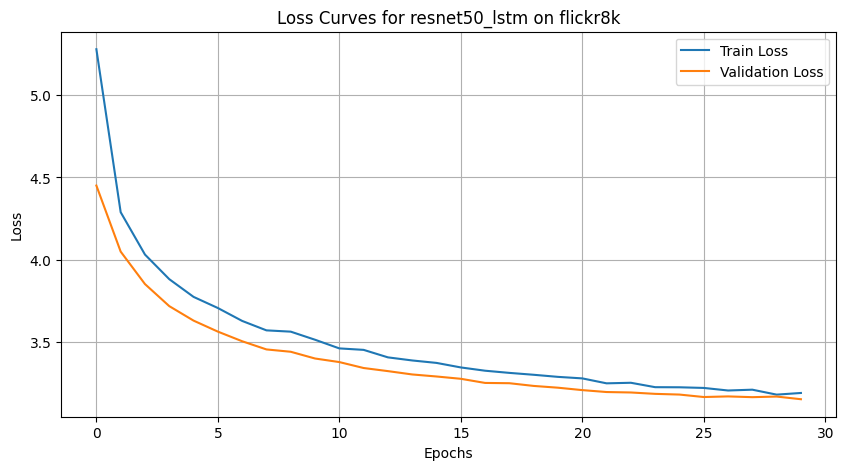

#### Evaluation Metrics

|   Bleu_1 |   Bleu_2 |   Bleu_3 |   Bleu_4 |   METEOR |   ROUGE_L |   CIDEr |   SPICE |
|---------:|---------:|---------:|---------:|---------:|----------:|--------:|--------:|
|    0.587 |    0.389 |    0.243 |    0.153 |    0.167 |     0.417 |   0.331 |   0.101 |


           QUALITATIVE ANALYSIS: GENERATED CAPTIONS



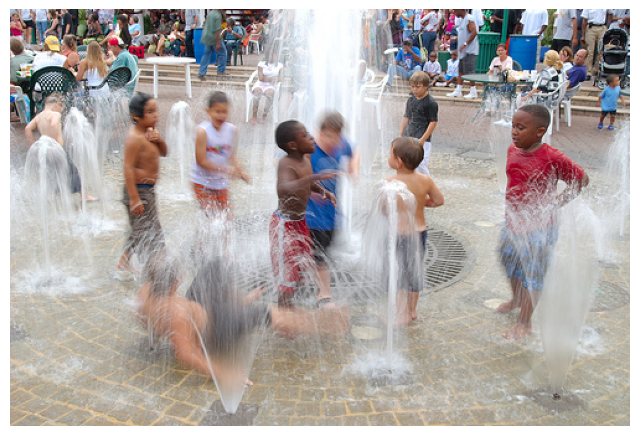

**Generated Caption:** `a group of people are walking on a beach`

**Ground Truths:**

- *a group of children from many races are standing in the fountain of a busy plaza *

- *children play in fountains that spray water from the ground *

- *children running through fountains of water in the midst of crowd *

- *little kids are playing in a water fountain in front of lots of people *

- *several children are playing in water fountains *

--------------------------------------------------


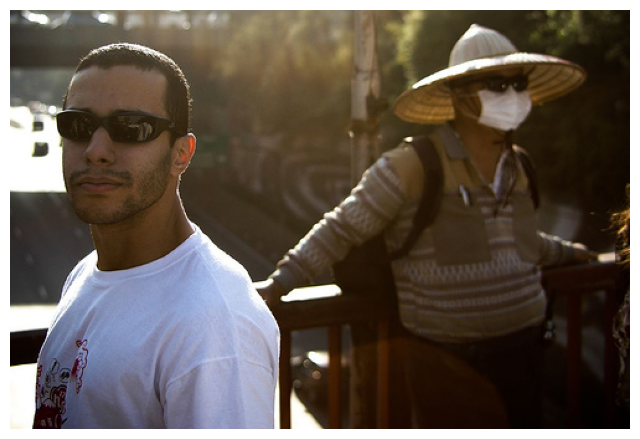

**Generated Caption:** `a man wearing a black shirt is standing on a bench`

**Ground Truths:**

- *a man in sunglasses on an overpass *

- *a man looking at the camera with another man wearing a mask *

- *a man wearing sunglasses is standing next to a person who is wearing a hat and breathing mask *

- *the man is wearing a white shirt and sunglasses *

- *there are two men with sunglasses one of which is wearing a hat and a backpack *

--------------------------------------------------


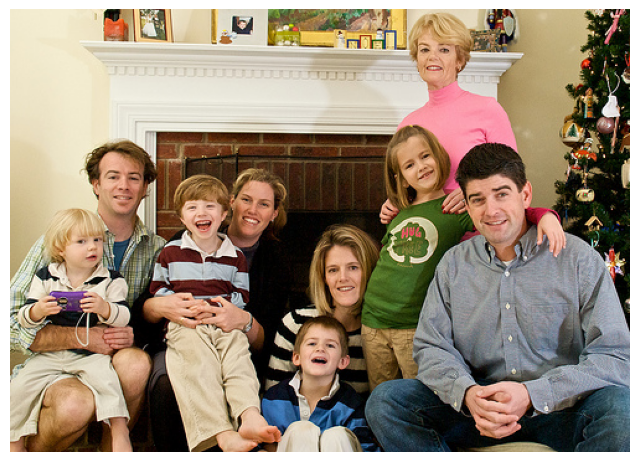

**Generated Caption:** `two women are sitting on a bench`

**Ground Truths:**

- *a family of nine people including four children pose in front of a brick fireplace with a white mantle *

- *a family poses in front of the fireplace and christmas tree *

- *a family posing by the mantle and christmas tree *

- *a happy family poses by the fireplace *

- *two couples and four kids pose for a family picture *

--------------------------------------------------


## 📊 Results for Dataset: `flickr30k`

### 🔬 Experiment: `resnet50_lstm`

**Performance Summary for flickr30k - resnet50 + lstm**
| Metric | Value |
| :--- | :--- |
| **GPU Used** | NVIDIA GeForce RTX 4090 |
| **Total Parameters** | 38,611,916 |
| **Trainable Parameters** | 30,068,620 |
| | |
| **Trainable Breakdown** | |
| &nbsp; &nbsp; Encoder | 14,964,736 |
| &nbsp; &nbsp; Decoder | 14,054,796 |
| &nbsp; &nbsp; Projection Head | 1,049,088 |
| | |
| **Training Details** | |
| &nbsp; &nbsp; Total Epochs Trained | 30 |
| &nbsp; &nbsp; Batch Size | 96 |
| &nbsp; &nbsp; Decoder LR | 0.00015 |
| &nbsp; &nbsp; Encoder LR | 0.0001 |
| &nbsp; &nbsp; Optimizer | AdamW |
| &nbsp; &nbsp; Vocab Size | 9612 |
| &nbsp; &nbsp; Dropout | 0.3 |
| &nbsp; &nbsp; LSTM Hidden Size | 512 |
| &nbsp; &nbsp; LSTM Layers | 2 |
| | |
| **Timings** | |
| &nbsp; &nbsp; Total Training Time | 3793.62 s (63.23 min) |
| &nbsp; &nbsp; Average Time per Epoch | 69.28 s |
| &nbsp; &nbsp; Average Time per Iteration | 0.0466 s |


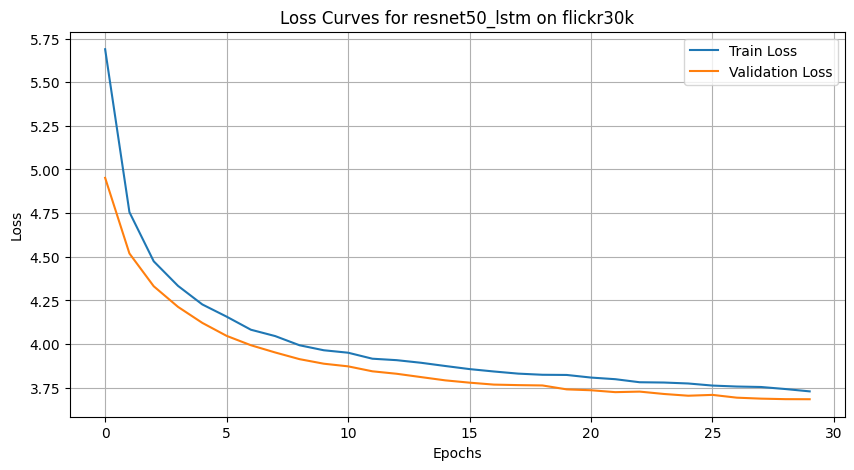

#### Evaluation Metrics

|   Bleu_1 |   Bleu_2 |   Bleu_3 |   Bleu_4 |   METEOR |   ROUGE_L |   CIDEr |   SPICE |
|---------:|---------:|---------:|---------:|---------:|----------:|--------:|--------:|
|    0.559 |    0.365 |    0.228 |    0.146 |    0.156 |     0.402 |   0.202 |   0.088 |


           QUALITATIVE ANALYSIS: GENERATED CAPTIONS



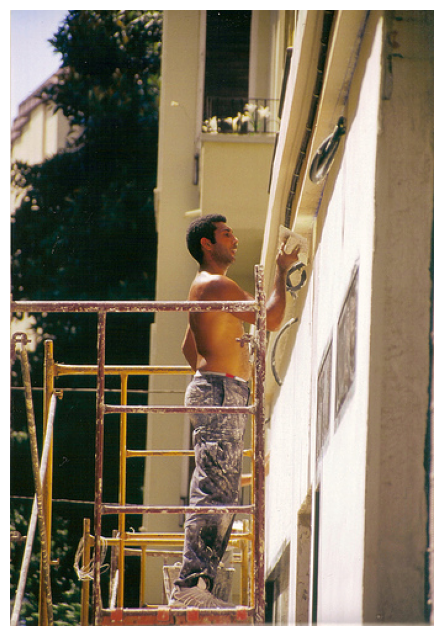

**Generated Caption:** `a man in a blue shirt is standing on a bench`

**Ground Truths:**

- *a shirtless tanned male with black hair wearing paint stained blue jeans and sneakers putting plaster along a building s wall *

- *a man without a shirt on is doing work on the side of a building *

- *a man is on a scaffold working on the outside of a building *

- *a man with no shirt standing on a scaffolding *

- *a man with no shirt is standing on a scaffold *

--------------------------------------------------


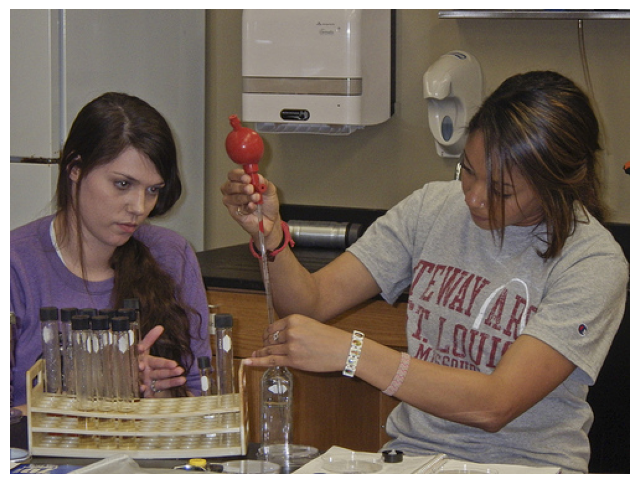

**Generated Caption:** `a woman in a black shirt is sitting on a bench`

**Ground Truths:**

- *two high schoolgirls complete a lab experiment as one adds drops to a mixture while the other observes *

- *a girl is working on some sort of lab experiment while another girl watches with a bored expression *

- *two young women in a lab doctor s office or classroom filling vials *

- *two girls are putting a chemical in a bottle *

- *two girls doing a science experiment *

--------------------------------------------------


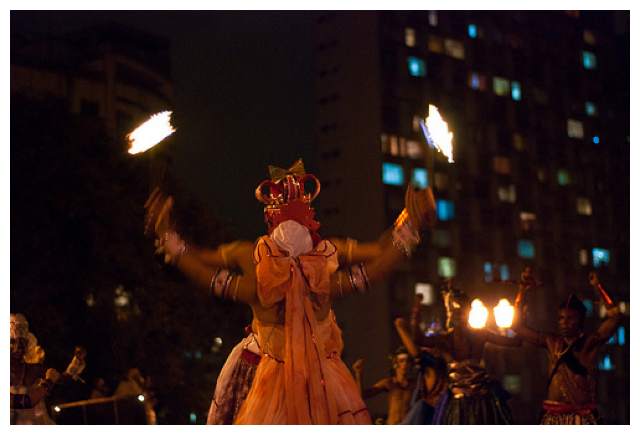

**Generated Caption:** `a man in a black shirt and a black shirt is standing in front of a crowd of people`

**Ground Truths:**

- *two people one man and one woman are celebrating and dancing in what seems like a festival *

- *a man and a woman in colorful costumes are performing a dance at night *

- *several fire dancers participated in a ritual in front of onlookers *

- *festival with 7 people in the night holding up there hands *

- *two fire dancers performing at night *

--------------------------------------------------


In [10]:
def plot_loss_curves(history, exp_name, dataset_name):
    if not history or 'train_loss' not in history or 'valid_loss' not in history:
        print("No training history found to plot.")
        return
    
    plt.figure(figsize=(10, 5))
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['valid_loss'], label='Validation Loss')
    plt.title(f'Loss Curves for {exp_name} on {dataset_name}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

def display_metrics_table(metrics):
    if not metrics:
        print("No metrics to display.")
        return
    
    df = pd.DataFrame([metrics])
    df = df.round(3)
    display(Markdown(df.to_markdown(index=False)))

def display_performance_summary(run_data):
    model = run_data['model']
    training_history = run_data['history']
    total_training_duration = run_data.get('duration', 0)
    train_loader_len = run_data.get('train_loader_len', 0)
    cfg = run_data['cfg']
    config = run_data['config']

    if training_history:
        total_epochs_trained = len(training_history['train_loss'])
        avg_epoch_time = sum(training_history['epoch_times']) / len(training_history['epoch_times']) if training_history.get('epoch_times') else 0
        iterations_per_epoch = train_loader_len
        avg_iteration_time = avg_epoch_time / iterations_per_epoch if iterations_per_epoch > 0 else 0
    else:
        total_epochs_trained = "N/A (Loaded from checkpoint)"
        avg_epoch_time = 0
        avg_iteration_time = 0

    # Parameter breakdown
    encoder_params = sum(p.numel() for p in model.encoder.parameters() if p.requires_grad)
    decoder_params = sum(p.numel() for p in model.decoder.parameters() if p.requires_grad)
    proj_params = 0
    if hasattr(model, 'feature_proj'):
        proj_params = sum(p.numel() for p in model.feature_proj.parameters() if p.requires_grad)
    
    summary_md = f"""**Performance Summary for {config['dataset_name']} - {cfg.encoder_name} + {cfg.decoder_name}**
| Metric | Value |
| :--- | :--- |
| **GPU Used** | {torch.cuda.get_device_name(0) if cfg.device.type == 'cuda' else 'CPU'} |
| **Total Parameters** | {sum(p.numel() for p in model.parameters()):,} |
| **Trainable Parameters** | {sum(p.numel() for p in model.parameters() if p.requires_grad):,} |
| | |
| **Trainable Breakdown** | |
| &nbsp; &nbsp; Encoder | {encoder_params:,} |
| &nbsp; &nbsp; Decoder | {decoder_params:,} |
"""
    if proj_params > 0:
        summary_md += f"| &nbsp; &nbsp; Projection Head | {proj_params:,} |\n"

    summary_md += f"""| | |
| **Training Details** | |
| &nbsp; &nbsp; Total Epochs Trained | {total_epochs_trained} |
| &nbsp; &nbsp; Batch Size | {cfg.batch_size} |
| &nbsp; &nbsp; Decoder LR | {cfg.decoder_lr} |
| &nbsp; &nbsp; Encoder LR | {cfg.encoder_lr} |
| &nbsp; &nbsp; Optimizer | AdamW |
| &nbsp; &nbsp; Vocab Size | {len(run_data['vocab'])} |
| &nbsp; &nbsp; Dropout | {cfg.dropout} |
"""
    if cfg.decoder_name == 'lstm':
        summary_md += f"| &nbsp; &nbsp; LSTM Hidden Size | {cfg.hidden_dim} |\n"
        summary_md += f"| &nbsp; &nbsp; LSTM Layers | {cfg.num_layers} |\n"

    summary_md += f"""| | |
| **Timings** | |
| &nbsp; &nbsp; Total Training Time | {total_training_duration:.2f} s ({total_training_duration/60:.2f} min) |
| &nbsp; &nbsp; Average Time per Epoch | {avg_epoch_time:.2f} s |
| &nbsp; &nbsp; Average Time per Iteration | {avg_iteration_time:.4f} s |
"""
    display(Markdown(summary_md))

def show_qualitative_results(run_data, num_examples=3):
    if 'generated_captions' not in run_data or 'ground_truths' not in run_data:
        print("Qualitative results not available.")
        return
        
    print("\n" + "="*50)
    print("           QUALITATIVE ANALYSIS: GENERATED CAPTIONS")
    print("="*50 + "\n")
    
    generated_map = {item['image_id']: item['caption'] for item in run_data['generated_captions']}
    gt_map = {}
    for ann in run_data['ground_truths']['annotations']:
        img_id = ann['image_id']
        if img_id not in gt_map:
            gt_map[img_id] = []
        gt_map[img_id].append(ann['caption'])
        
    image_ids = random.sample(list(generated_map.keys()), min(num_examples, len(generated_map)))
    
    for image_id in image_ids:
        image_path = os.path.join(run_data['config']['image_dir'], image_id)
        if not os.path.exists(image_path):
            continue
            
        plt.figure(figsize=(8, 8))
        image = Image.open(image_path)
        plt.imshow(image)
        plt.axis('off')
        plt.show()
        
        display(Markdown(f"**Generated Caption:** `{generated_map[image_id]}`"))
        display(Markdown("**Ground Truths:**"))
        for gt_caption in gt_map.get(image_id, []):
            display(Markdown(f"- *{gt_caption}*"))
        print("-"*50)
        

def generate_final_report(results):
    print("\n" + "="*60)
    print("           FINAL COMPARATIVE ANALYSIS")
    print("="*60 + "\n")
    
    for dataset_name, exps in results.items():
        display(Markdown(f'## 📊 Results for Dataset: `{dataset_name}`'))
        for exp_name, run_data in exps.items():
            display(Markdown(f'### 🔬 Experiment: `{exp_name}`'))
            
            # --- Performance Summary ---
            display_performance_summary(run_data)
            
            # --- Loss Curves ---
            plot_loss_curves(run_data.get('history'), exp_name, dataset_name)
            
            # --- Metrics Table ---
            display(Markdown("#### Evaluation Metrics"))
            display_metrics_table(run_data.get('metrics'))
            
            # --- Qualitative Examples ---
            if run_data['cfg'].run_evaluation:
                show_qualitative_results(run_data)
            
            sys.stdout.flush() # Ensure outputs are displayed in order
            time.sleep(1.0)


if __name__ == '__main__':
    if BaseCFG.run_evaluation:
        generate_final_report(results_history)


### **Final Review Checklist**
This checklist confirms that all identified bugs and robustness improvements have been integrated into the script.

| ID | Status | Description | Location of Fix |
| :--- | :--- | :--- | :--- |
| 1 | ✅ | Dependencies are explicitly installed (`pycocoevalcap`, `albumentations`, `tabulate`). | Step 1 |
| 2 | ✅ | System dependencies (`java`, `zip`) are installed. | Step 1 |
| 3 | ✅ | A compatible PyTorch version is forcibly installed to prevent CUDA errors. | Step 1 |
| 4 | ✅ | A compatible NumPy version (`<2.0`) is explicitly installed. | Step 1 |
| 5 | ✅ | The data processing pipeline correctly parses image filenames from `captions.txt`. | Step 3 |
| 6 | ✅ | The `torch.load` call for the vocabulary object uses `weights_only=False`. | Step 8 |
| 7 | ✅ | Teacher-forcing slicing (`[:, :-1]`) is handled correctly and consistently in the `Trainer`. | Step 6 |
| 8 | ✅ | The GPT-2 `generate` method is correctly passed the `eos_token_id`. | Step 5 |
| 9 | ✅ | The ground-truth JSON for evaluation includes the required `"info"` key. | Step 7 |
| 10 | ✅ | The `base_path` variable is correctly defined in the global scope. | Step 1 |